In [36]:
import logging
import pandas as pd
import numpy as np  
import geopandas as gpd
from io import StringIO
import matplotlib.pyplot as plt

class GeoCleaner:
    def __init__(self, file):
        self.info_buffer = StringIO()
        self.file = file
        self.df = None
        self.regions_level2 = gpd.read_file("../country_boundaries/gadm41_FRA_shp/gadm41_FRA_2.shp")
        self.logger = self.setup_logger()

    def setup_logger(self):
        logger = logging.getLogger('data_cleaner')
        logger.setLevel(logging.DEBUG)  # Default logging level
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        
        # Add console handler
        ch = logging.StreamHandler()
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        
        # Add file handler
        log_file_name = f"data_cleaner.log"
        fh = logging.FileHandler(log_file_name)
        fh.setFormatter(formatter)
        logger.addHandler(fh)
        
        return logger

    
    def load_data(self):
        self.logger.info("Loading data...")
        try:
            self.df = pd.read_csv(self.file)
            self.logger.info(f"Data loaded successfully from {self.file}")
        except Exception as e:
            self.logger.error(f"Error loading data: {str(e)}")

    def check_data(self):
        self.logger.info("Checking data...")
        try:
            self.logger.info(f"Unique main categories:\n{self.df['main_category'].unique()}")
            self.logger.info(f"Main categories distributions:\n{self.df['main_category'].value_counts()}")
            # Capture the output of df.info()
            self.info_buffer = StringIO()
            self.df.info(buf=self.info_buffer)
            info_string = self.info_buffer.getvalue()
            # Log the captured information
            self.logger.info(f"Info:\n{info_string}")
            self.logger.info("Data check completed.")
        except Exception as e:
            self.logger.error(f"Error checking data: {str(e)}")
        
    def remove_unwanted_columns(self):
        initial_columns = len(self.df.columns)
        self.logger.info("Removing unwanted columns...")
        try:
            desired_columns = ["name", "website", "main_category", "categories", "phone", "address", "coordinates", "link"]
            self.df = self.df[desired_columns]
            self.logger.info("Unwanted columns removed.")
            removed_columns = initial_columns - len(self.df.columns)
            self.logger.info(f"Removed {removed_columns} columns")
        except Exception as e:
            self.logger.error(f"Error removing unwanted columns: {str(e)}")

    def remove_null_and_duplicates(self):
    
        self.logger.info("Removing null values and duplicates...")
        try:
            initial_rows = len(self.df)
            self.df.dropna(subset=["coordinates"], inplace=True)
            removed_rows = initial_rows - len(self.df)
            self.logger.info(f"Removed {removed_rows} rows with null values")
            self.df.drop_duplicates(subset=['coordinates'] ,inplace=True)
            initial_rows = len(self.df)
            self.logger.info("Null values and duplicates removed.")
            removed_rows = initial_rows - len(self.df)
            self.logger.info(f"Removed {removed_rows} rows with duplicate values")
        except Exception as e:
            self.logger.error(f"Error removing null values and duplicates: {str(e)}")
    
    def format_main_categories(self):
        self.logger.info("Formatting main categories...")
        try:
            self.df[['latitude','longitude']] = self.df['coordinates'].str.split(',', expand=True)
            self.df['main_category'] = self.df['main_category'].str.lower().str.strip().str.replace(" ", "_")
            self.logger.info("Main categories formatted.")
        except Exception as e:
            self.logger.error(f"Error formatting main categories: {str(e)}")

    def format_categories(self):
        self.logger.info("Formatting categories...")
        try:
            def translate_categories(category_list):
                translated_list = []
                if isinstance(category_list, float) and np.isnan(category_list):
                    return translated_list
                for category in category_list.split(", "):
                    translated_list.append(category.str.lower().str.strip().str.replace(" ", "_"))
                return translated_list
            self.df['categories'] = self.df['categories'].apply(translate_categories)
            self.logger.info("Categories formatted.")
            self.logger.info(f"Categories distributions:\n{self.df['categories'].value_counts()}")
        except Exception as e:
            self.logger.error(f"Error formatting categories: {str(e)}")
    
    def keep_specific_categories(self):
        self.logger.info("Keeping specific categories...")
        try:
            main_categories_keywords = {
                "diagnostic_lab", "clinical_lab", "medical_lab",
                "testing_lab",  "diagnostic_testing_lab", "s2_diagnostics_lab", 
                "laboratory_services",
                "s2_diagnostic_facility",
                'medical_laboratory', 'diagnostic_center', 'laboratory'
            }
            keywords = {
                "diagnostic_lab", "clinical_lab", "medical_lab",
                "testing_lab",  "diagnostic_testing_lab", "s2_diagnostics_lab", 
                "laboratory_services",
                "s2_diagnostic_facility",
                'medical_laboratory', 'diagnostic_center', 'laboratory'
            }
            
            self.df = self.df[self.df['main_category'].isin(main_categories_keywords)]
            self.logger.info("Rows kept based on main_category column.")
            
            def check_keywords(category_list):
                if isinstance(category_list, float) and np.isnan(category_list):
                    pass
                for category in category_list:
                    if category in keywords:
                        return True
                return False
            
            self.df['contains_keyword'] = self.df['categories'].apply(check_keywords)
            self.df = self.df[self.df['contains_keyword']]
            self.logger.info("Keywords checked.")
            
            self.df.drop(columns=['contains_keyword'], inplace=True)
            self.df.reset_index(drop=True, inplace=True)
            self.logger.info("Specific categories kept.")
            
            def filter_categories(category_list):
                if isinstance(category_list, float) and np.isnan(category_list):
                    return []
                return [category for category in category_list if category in keywords]
            
            self.df['categories'] = self.df['categories'].apply(filter_categories)
            self.logger.info("Categories filtered.")
            
            keywords2 = {
                "diagnostic_lab", "clinical_lab", "medical_lab",
                "testing_lab",  "diagnostic_testing_lab", "s2_diagnostics_lab", 
                "laboratory_services",
                "s2_diagnostic_facility",
                'medical_laboratory', 'diagnostic_center', 'laboratory'
            }
            
            def update_main_category(row):
                if row['main_category'] not in keywords2:
                    if len(row['categories']) == 1:
                        if row['categories'][0] in keywords2:
                            return row['categories'][0]
                        else:
                            return "multiple"
                    else:
                        return "multiple"
                return row['main_category']
            
            self.df['main_category'] = self.df.apply(update_main_category, axis=1)
            self.logger.info("Main categories updated.")
        except Exception as e:
            self.logger.error(f"Error keeping specific categories: {str(e)}")
  
        
    def transform_gpd(self):
        self.logger.info("Converting the DataFrame to a GeoDataFrame...")
        try:
            self.df['latitude'] = self.df['latitude'].replace('None', np.nan)
            self.df['longitude'] = self.df['longitude'].replace('None', np.nan)
            self.df.dropna(subset=['longitude'], inplace=True)
            self.df = gpd.GeoDataFrame(self.df, geometry=gpd.points_from_xy(self.df.longitude, self.df.latitude))
            self.df.crs = {'init': 'epsg:4326'}
            self.logger.info("GeoDataFrame created with CRS: 4326")
        except Exception as e:
            self.logger.error(f"Error converting DataFrame to GeoDataFrame: {str(e)}")
        
    def assign_region(self):
        self.logger.info("Assigning region and state to farms...")
        try:
            joined_gdf = gpd.sjoin(self.df, self.regions_level2, how="left", op="within")
            #joined_gdf = joined_gdf.dropna(subset=['COUNTRY'])
            #desired_columns = ['COUNTRY','NAME_1', 'NAME_2']
            joined_gdf = joined_gdf.dropna(subset=['NAME_0'])
            desired_columns = ['NAME_0','NAME_1', 'NAME_2']
            joined_gdf_filtered = joined_gdf[desired_columns]
            joined_gdf_final = self.df.merge(joined_gdf_filtered, left_index=True, right_index=True)
            #joined_gdf_final.rename(columns={'COUNTRY': 'country', 'NAME_1': 'state', 'NAME_2': 'department'}, inplace=True)
            joined_gdf_final.rename(columns={'NAME_0': 'country', 'NAME_1': 'state', 'NAME_2': 'department'}, inplace=True)
            self.logger.info(f"Farms by department:\n{joined_gdf_final.department.value_counts()}")
            self.logger.info(f"Farms by state:\n{joined_gdf_final.state.value_counts()}")
            self.df = joined_gdf_final
        except Exception as e:
            self.logger.error(f"Error assigning region and state: {str(e)}")
        
    def data_validation(self):
        # Check for null values in specific columns
        try:
            null_columns = self.df.columns[self.df.isnull().any()]
            if not null_columns.empty:
                self.logger.info(f"Null values found in columns: {', '.join(null_columns)}")
        except Exception as e:
            self.logger.error(f"Error checking for null values: {str(e)}")

        # Check for outliers in numerical columns
        try:
            numerical_columns = self.df.select_dtypes(include=np.number).columns
            for column in numerical_columns:
                outliers = self.find_outliers(self.df[column])
                if outliers:
                    self.logger.info(f"Outliers found in column {column}: {outliers}")
        except Exception as e:
            self.logger.error(f"Error checking for outliers: {str(e)}")


    def find_outliers(self, series):
        # Detect outliers using standard deviation
        try:
            mean = series.mean()
            std = series.std()
            lower_bound = mean - 2 * std
            upper_bound = mean + 2 * std
            outliers = series[(series < lower_bound) | (series > upper_bound)]
            return outliers.tolist()
        except Exception as e:
            self.logger.error(f"Error finding outliers: {str(e)}")

    def clean(self):
        try:
            self.load_data()
            self.remove_unwanted_columns()
            self.remove_null_and_duplicates()
            self.format_main_categories()
            self.check_data()
            self.format_categories()
            self.keep_specific_categories()
            self.check_data()
            self.check_data()
            self.transform_gpd()
            self.check_data()
            self.assign_region()
            self.check_data()
            self.check_data()
            self.data_validation()
            self.df.to_csv(f"processed_data_lab", index=False)
            self.logger.info(f"Cleaning process completed. Cleaned data saved to {self.file.replace('.csv', '_cleaned.csv')}")
        except Exception as e:
            self.logger.error(f"Error in cleaning process: {str(e)}")



In [37]:
cleaner = GeoCleaner("/Users/rodrigoazevedo/repos/geopandas/data/lab_raw_csv/labs_france.csv")
cleaner.load_data()

2024-05-20 19:50:47,812 - INFO - Loading data...
2024-05-20 19:50:47,812 - INFO - Loading data...
2024-05-20 19:50:47,812 - INFO - Loading data...
2024-05-20 19:50:47,812 - INFO - Loading data...
/var/folders/kj/s6p553_17zxd38q2s490jgr80000gn/T/ipykernel_88505/2706403271.py:38: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(self.file)
2024-05-20 19:50:48,163 - INFO - Data loaded successfully from /Users/rodrigoazevedo/repos/geopandas/data/lab_raw_csv/labs_france.csv
2024-05-20 19:50:48,163 - INFO - Data loaded successfully from /Users/rodrigoazevedo/repos/geopandas/data/lab_raw_csv/labs_france.csv
2024-05-20 19:50:48,163 - INFO - Data loaded successfully from /Users/rodrigoazevedo/repos/geopandas/data/lab_raw_csv/labs_france.csv
2024-05-20 19:50:48,163 - INFO - Data loaded successfully from /Users/rodrigoazevedo/repos/geopandas/data/lab_raw_csv/labs_france.csv


In [38]:
cleaner.remove_unwanted_columns()

2024-05-20 19:51:02,497 - INFO - Removing unwanted columns...
2024-05-20 19:51:02,497 - INFO - Removing unwanted columns...
2024-05-20 19:51:02,497 - INFO - Removing unwanted columns...
2024-05-20 19:51:02,497 - INFO - Removing unwanted columns...
2024-05-20 19:51:02,506 - INFO - Unwanted columns removed.
2024-05-20 19:51:02,506 - INFO - Unwanted columns removed.
2024-05-20 19:51:02,506 - INFO - Unwanted columns removed.
2024-05-20 19:51:02,506 - INFO - Unwanted columns removed.
2024-05-20 19:51:02,508 - INFO - Removed 12 columns
2024-05-20 19:51:02,508 - INFO - Removed 12 columns
2024-05-20 19:51:02,508 - INFO - Removed 12 columns
2024-05-20 19:51:02,508 - INFO - Removed 12 columns


In [39]:
#cleaner.remove_null_and_duplicates()
cleaner.format_main_categories()

2024-05-20 19:51:12,794 - INFO - Formatting main categories...
2024-05-20 19:51:12,794 - INFO - Formatting main categories...
2024-05-20 19:51:12,794 - INFO - Formatting main categories...
2024-05-20 19:51:12,794 - INFO - Formatting main categories...
2024-05-20 19:51:12,846 - INFO - Main categories formatted.
2024-05-20 19:51:12,846 - INFO - Main categories formatted.
2024-05-20 19:51:12,846 - INFO - Main categories formatted.
2024-05-20 19:51:12,846 - INFO - Main categories formatted.


In [40]:
cleaner.df['main_category'].value_counts()

main_category
medical_laboratory                   32357
laboratory                            2057
diagnostic_center                     1045
x-ray_lab                              860
estate_appraiser                       540
                                     ...  
photo_restoration_service                1
electronics_manufacturer                 1
educational_testing_service              1
cultural_center                          1
electrical_equipment_manufacturer        1
Name: count, Length: 330, dtype: int64

In [42]:
cleaner.remove_null_and_duplicates()

2024-05-20 19:52:41,806 - INFO - Removing null values and duplicates...
2024-05-20 19:52:41,806 - INFO - Removing null values and duplicates...
2024-05-20 19:52:41,806 - INFO - Removing null values and duplicates...
2024-05-20 19:52:41,806 - INFO - Removing null values and duplicates...
2024-05-20 19:52:41,819 - INFO - Removed 0 rows with null values
2024-05-20 19:52:41,819 - INFO - Removed 0 rows with null values
2024-05-20 19:52:41,819 - INFO - Removed 0 rows with null values
2024-05-20 19:52:41,819 - INFO - Removed 0 rows with null values
2024-05-20 19:52:41,825 - INFO - Null values and duplicates removed.
2024-05-20 19:52:41,825 - INFO - Null values and duplicates removed.
2024-05-20 19:52:41,825 - INFO - Null values and duplicates removed.
2024-05-20 19:52:41,825 - INFO - Null values and duplicates removed.
2024-05-20 19:52:41,826 - INFO - Removed 0 rows with duplicate values
2024-05-20 19:52:41,826 - INFO - Removed 0 rows with duplicate values
2024-05-20 19:52:41,826 - INFO - Rem

In [27]:

cleaner.format_main_categories()
cleaner.check_data()
cleaner.format_categories()

2024-05-20 19:46:05,596 - INFO - Formatting main categories...
2024-05-20 19:46:05,596 - INFO - Formatting main categories...
2024-05-20 19:46:05,596 - INFO - Formatting main categories...
2024-05-20 19:46:05,620 - INFO - Main categories formatted.
2024-05-20 19:46:05,620 - INFO - Main categories formatted.
2024-05-20 19:46:05,620 - INFO - Main categories formatted.
2024-05-20 19:46:05,621 - INFO - Checking data...
2024-05-20 19:46:05,621 - INFO - Checking data...
2024-05-20 19:46:05,621 - INFO - Checking data...
2024-05-20 19:46:05,623 - INFO - Unique main categories:
['shopping_mall' 'x-ray_lab' 'hypermarket'
 'medical_diagnostic_imaging_center' 'medical_center'
 'do-it-yourself_shop' 'book_store' 'radiologist' 'medical_laboratory'
 'medical_clinic' 'home_improvement_store' 'herb_shop' 'general_hospital'
 'supermarket' 'private_hospital' 'gift_shop' 'building_materials_store'
 '3d_printing_service' 'lawn_mower_store' 'diagnostic_center' 'hospital'
 'walk-in_clinic' 'public_medical_ce

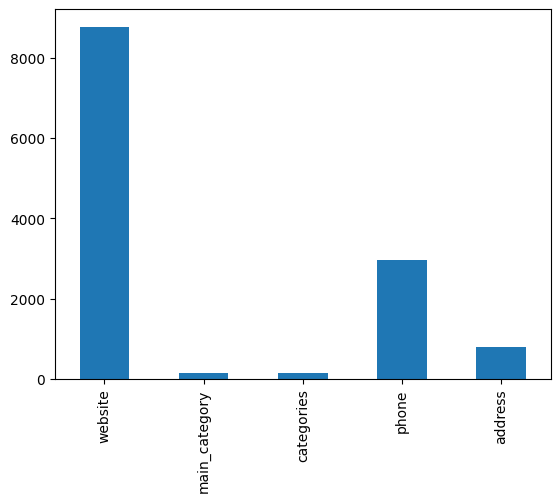

In [28]:
def plot_missing_values(df):
    # get the number of missing data points per column
    missing_values_count = df.isnull().sum()
    missing_values_count = missing_values_count[missing_values_count > 0]

    # plot the missing values
    missing_values_count.plot(kind="bar")
    plt.show()

plot_missing_values(cleaner.df)

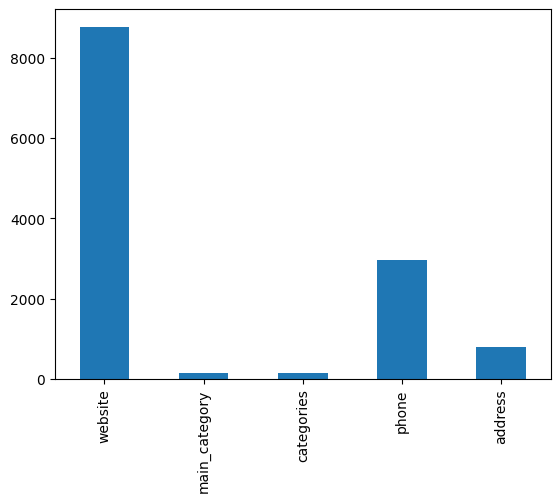

In [29]:
def plot_missing_values(df):
    # get the number of missing data points per column
    missing_values_count = df.isnull().sum()
    missing_values_count = missing_values_count[missing_values_count > 0]

    # plot the missing values
    missing_values_count.plot(kind="bar")
    plt.show()

plot_missing_values(cleaner.df)

In [30]:
# function to calculate the percentage of missing values
def missing_values(df):
    missing_values_count = df.isnull().sum()
    # how many total missing values do we have?
    total_cells = np.prod(df.shape)
    total_missing = missing_values_count.sum()

    # percent of data that is missing
    percent_missing = (total_missing/total_cells) * 100
    
    return percent_missing

print(missing_values(cleaner.df))

3.1172884662277496


In [31]:
# function to calculate the percentage of duplicates in the data
def percentage_duplicates(df):
    return df.duplicated().sum() / len(df) * 100

# calculate the percentage of duplicates in the data
print(percentage_duplicates(cleaner.df))

70.79736649597659


In [32]:
# number of duplicated values per column
duplicated_values_per_column = cleaner.df.apply(lambda x: x.duplicated().sum())

print("Duplicated values per column:")
print(duplicated_values_per_column)


Duplicated values per column:
name             31029
website          33948
main_category    40679
categories       39642
phone            32397
address          29627
coordinates      29604
link             29200
latitude         29646
longitude        29623
dtype: int64


In [33]:
# replace all null values with np.nan
cleaner.df.replace("", np.nan, inplace=True)
cleaner.df.replace("None", np.nan, inplace=True)

# check for null values in all columns
null_counts = cleaner.df.isnull().sum()
print("Null counts in each column:")
print(null_counts)

# remove all rows with at least one missing value in the "coordinates" column
df_with_na_dropped = cleaner.df.dropna(subset=['coordinates'])

# calculate number of dropped rows
rows_in_original_dataset = cleaner.df.shape[0]
rows_in_na_dropped = df_with_na_dropped.shape[0]
dropped_rows = rows_in_original_dataset - rows_in_na_dropped
print("Number of rows dropped due to missing values in 'coordinates' column:", dropped_rows)


Null counts in each column:
name                0
website          8772
main_category     135
categories        135
phone            2959
address           783
coordinates         0
link                0
latitude            1
longitude           1
dtype: int64
Number of rows dropped due to missing values in 'coordinates' column: 0


In [34]:
# Count the number of duplicated rows in the specified column
duplicated_rows_in_column = cleaner.df.duplicated(subset=['coordinates']).sum()

print("Number of duplicated rows in column coordinates': {}".format(duplicated_rows_in_column))
initial_rows = cleaner.df.shape[0]
cleaner.df.drop_duplicates(subset=['coordinates'], inplace=True)
print("Number of rows dropped due to duplicates:", initial_rows - cleaner.df.shape[0])

Number of duplicated rows in column coordinates': 29604
Number of rows dropped due to duplicates: 29604


In [35]:
null_counts = df.isna().sum()

# This will give you a Series containing the sum of null values in each column
print(null_counts)

NameError: name 'df' is not defined

In [ ]:
df.dropna(subset=["main_category"], inplace=True)

In [ ]:
print("Number of entries in dataset: ", df.shape[0])
df.main_category.value_counts()

Number of entries in dataset:  11321


main_category
Medical laboratory                   6953
Laboratory                            703
Diagnostic center                     600
X-ray lab                             447
Estate appraiser                      353
                                     ... 
Event planner                           1
House cleaning service                  1
Environmental engineer                  1
Coaching service                        1
Electrical equipment manufacturer       1
Name: count, Length: 323, dtype: int64

In [ ]:
print("Number of unique main categories", len(df.main_category.unique()))

Number of unique main categories 323


In [ ]:
df.main_category.unique()

array(['Shopping mall', 'X-ray lab', 'Hypermarket',
       'Medical diagnostic imaging center', 'Medical Center',
       'Do-it-yourself shop', 'Book store', 'Radiologist',
       'Medical laboratory', 'Medical clinic', 'Home improvement store',
       'Herb shop', 'General hospital', 'Supermarket', 'Private hospital',
       'Gift shop', 'Building materials store', '3D printing service',
       'Lawn mower store', 'Diagnostic center', 'Hospital',
       'Walk-in clinic', 'Public medical center', 'Estate appraiser',
       'Nursing home', 'Car dealer', 'Doctor', 'Laboratory',
       'Real estate surveyor', 'Surgical products wholesaler',
       'University', 'Surgical center', 'Photographer', 'Photo lab',
       'Real estate appraiser', 'Office supply store',
       'Car inspection station', 'MRI center', 'Recreation center',
       'Dog day care center', 'Bakery', 'Photography studio',
       'Tuning automobile', 'Graduate school',
       'Heating equipment supplier', 'Paternity testi

In [ ]:
df.main_category.unique()

array(['Shopping mall', 'X-ray lab', 'Hypermarket',
       'Medical diagnostic imaging center', 'Medical Center',
       'Do-it-yourself shop', 'Book store', 'Radiologist',
       'Medical laboratory', 'Medical clinic', 'Home improvement store',
       'Herb shop', 'General hospital', 'Supermarket', 'Private hospital',
       'Gift shop', 'Building materials store', '3D printing service',
       'Lawn mower store', 'Diagnostic center', 'Hospital',
       'Walk-in clinic', 'Public medical center', 'Estate appraiser',
       'Nursing home', 'Car dealer', 'Doctor', 'Laboratory',
       'Real estate surveyor', 'Surgical products wholesaler',
       'University', 'Surgical center', 'Photographer', 'Photo lab',
       'Real estate appraiser', 'Office supply store',
       'Car inspection station', 'MRI center', 'Recreation center',
       'Dog day care center', 'Bakery', 'Photography studio',
       'Tuning automobile', 'Graduate school',
       'Heating equipment supplier', 'Paternity testi

In [ ]:
values_to_remove = ['Shopping mall', 'X-ray lab', 'Hypermarket',
       'Medical diagnostic imaging center', 'Medical Center',
       'Do-it-yourself shop', 'Book store', 'Radiologist',
       'Medical clinic', 'Home improvement store',
       'Herb shop', 'General hospital', 'Supermarket', 'Private hospital',
       'Gift shop', 'Building materials store', '3D printing service',
       'Lawn mower store', 'Hospital',
       'Walk-in clinic', 'Public medical center', 'Estate appraiser',
       'Nursing home', 'Car dealer', 'Doctor',
       'Real estate surveyor', 'Surgical products wholesaler',
       'University', 'Surgical center', 'Photographer', 'Photo lab',
       'Real estate appraiser', 'Office supply store',
       'Car inspection station', 'MRI center', 'Recreation center',
       'Dog day care center', 'Bakery', 'Photography studio',
       'Tuning automobile', 'Graduate school',
       'Heating equipment supplier', 'Paternity testing service',
       'Car racing track', 'Vaporizer store', 'Pet supply store',
       'Portrait studio', 'College', 'Phone repair service',
       'Roofing contractor', 'Pharmacy', 'Photo shop',
       'Passport photo processor', 'Research institute',
       'Blood donation center', 'Establishment', 'Motorcycle repair shop',
       'Physical therapy clinic', 'Pathologist', 'Home inspector',
       'Janitorial service', 'Market researcher', 'Restaurant',
       'Physical therapist', 'Repair service', 'Science museum',
       'Medical supply store', 'Cosmetic products manufacturer',
       'Resident registration office', 'Dental clinic', 'Dyeworks',
       'Sewage treatment plant', 'High school', 'Research engineer',
       'Digital printing service', 'Trucking company', 'Oilfield',
       'Housing society', 'Electrical equipment manufacturer']
   

# remove rows with the values in the list above
df = df[~df['main_category'].isin(values_to_remove)]


In [ ]:
df.main_category.unique()

array(['Medical laboratory', 'Diagnostic center', 'Laboratory',
       'Local medical services', 'Outlet store', 'Garage door supplier',
       'Dog breeder', 'Veterinarian', 'Mobile phone repair shop',
       'Wellness center', 'Biochemistry lab', 'Wedding photographer',
       'Government office', 'Pharmaceutical company',
       'Commercial photographer', 'Technology park', 'Beauty salon',
       'Corporate office', 'Photography service', 'Camera store',
       'Computer service', 'Hair replacement service',
       'Pharmaceutical lab', 'Adult education school',
       'General contractor', 'Blood testing service',
       'Regional government office', 'Psychologist',
       'Data recovery service', 'Dental laboratory', 'Fertility clinic',
       'Vitamin & supplements store', 'Medical office', 'Midwife',
       'Computer repair service', 'Computer store',
       'Pest control service', 'Sports medicine physician',
       'Coworking space', 'Travel clinic', 'Print shop',
       'Cham

In [ ]:
values_to_remove = [
       'Local medical services', 'Outlet store', 'Garage door supplier',
       'Dog breeder', 'Veterinarian', 'Mobile phone repair shop',
       'Wellness center', 'Wedding photographer',
       'Government office', 'Pharmaceutical company',
       'Commercial photographer', 'Technology park', 'Beauty salon',
       'Corporate office', 'Cosmetics store', 'Photography service',
       'Camera store', 'Computer service', 'Hair replacement service',
        'Adult education school',
       'General contractor', 'Blood testing service',
       'Regional government office', 'Psychologist',
       'Data recovery service', 'Dental laboratory', 'Fertility clinic',
       'Vitamin & supplements store', 'Medical office', 'Midwife',
       'Computer repair service', 'Computer store',
       'Pest control service', 'Sports medicine physician',
       'Coworking space', 'Travel clinic', 'Print shop',
       'Chamber of agriculture', 'Psychiatric hospital',
       'Logistics service', 'Faculty of science',
       'Environmental consultant', 'Plant nursery',
       'Occupational health service', 'Home help service agency',
       'Building inspector', 'Business park', 'Sports medicine clinic',
       'Stationery store', 'Research and product development',
       'Event management company', 'Registered general nurse', 'Council',
       'Video production service', 'County government office',
       'Manufacturer', 'Cannabis store', 'Sanitation service',
       'Accounting firm', 'Labor union', 'Instrumentation engineer',
       'Media consultant', 'Education center',
       'Farm equipment repair service', 'Skin care clinic',
       'English language school', 'Bus stop', 'Optician', 'Plumber']
     
# remove rows with the values in the list above
df = df[~df['main_category'].isin(values_to_remove)]

In [ ]:
df.main_category.unique()

array(['Medical laboratory', 'Diagnostic center', 'Laboratory',
       'Biochemistry lab', 'Pharmaceutical lab', 'Biotechnology company',
       'Research foundation', 'Temp agency', 'Advertising agency',
       'Asbestos testing service', 'General practitioner',
       'Wellness program', 'Software company', 'Chemical plant',
       'Engineering consultant', 'Real estate agency', 'Sports complex',
       'Soil testing service', 'Association / Organization',
       'Perfume store', 'Food processing company', 'Bilingual school',
       'Photo restoration service', 'Business to business service',
       'Volunteer organization', 'Cultural center', 'Engineer',
       'Cosmetics industry', 'Visitor center', 'Earth works company',
       'Oncologist', 'Community health centre',
       'Industrial engineers association', 'Community center',
       'Makerspace', 'Real estate consultant', 'Arts organization',
       'Tattoo and piercing shop', 'Furniture manufacturer',
       'Water testing se

In [ ]:
values_to_remove = [ 'Temp agency', 'Advertising agency',
       'Asbestos testing service', 'General practitioner',
       'Wellness program', 'Software company', 'Chemical plant',
       'Engineering consultant', 'Real estate agency', 'Sports complex',
       'Soil testing service', 'Association / Organization',
       'Perfume store', 'Food processing company', 'Bilingual school',
       'Photo restoration service', 'Business to business service',
       'Volunteer organization', 'Cultural center', 'Engineer',
       'Cosmetics industry', 'Visitor center', 'Earth works company',
       'Oncologist', 'Community health centre',
       'Industrial engineers association', 'Community center',
       'Makerspace', 'Real estate consultant', 'Arts organization',
       'Tattoo and piercing shop', 'Furniture manufacturer',
       'Water testing service', 'Appraiser', 'Bakery equipment',
       'Home health care service', 'Learning center',
       'Specialized hospital', 'Audio visual equipment supplier',
       'Orthopedic surgeon', 'Medical equipment supplier',
       'Dialysis center', 'Window tinting service', 'Psychotherapist',
       'Occupational safety and health', 'School', 'Digital printer',
       'Local government office', 'Information services', 'Chemistry lab',
       'Occupational medical physician', 'Chemical manufacturer',
       'Consultant', 'Laboratory equipment supplier', 'Siding contractor',
       'Contractor', 'Website designer', 'Medical equipment manufacturer',
       'Car repair and maintenance service', 'Mechanic',
       'Boot repair shop', 'Telecommunications service provider',
       'Historical place', 'Gym', 'Heating contractor', 'Pediatrician',
       'Allergist', 'Orthoptist', 'Business center', 'Animal hospital']

# remove rows with the values in the list above
df = df[~df['main_category'].isin(values_to_remove)]

In [ ]:
df.main_category.unique()

array(['Medical laboratory', 'Diagnostic center', 'Laboratory',
       'Biochemistry lab', 'Pharmaceutical lab', 'Biotechnology company',
       'Research foundation', 'Non-profit organization',
       'Personal trainer', 'Corporate campus', 'Mental health service',
       'Event planner', 'Store', 'Cultural association',
       'House cleaning service', 'Environmental engineer',
       'Coaching service', 'Laser hair removal service', 'Glass industry',
       'Car wash', 'Industrial gas supplier', 'Art gallery',
       'Medical group', 'Insurance company', 'Denture care center',
       'Computer support and services', 'Real estate agent', 'Seminary',
       'Furniture maker', 'Federal government office',
       'Academic department', 'Water treatment supplier',
       'Structural engineer', 'Animal control service',
       'Machining manufacturer', 'Air conditioning contractor',
       'Building consultant', 'Judo club',
       'Disability services and support organization',
       'M

In [ ]:
values_to_remove = [
       
       'Research foundation', 'Non-profit organization',
       'Personal trainer', 'Corporate campus', 'Mental health service',
       'Event planner', 'Store', 'Cultural association',
       'House cleaning service', 'Environmental engineer',
       'Coaching service', 'Laser hair removal service', 'Glass industry',
       'Car wash', 'Industrial gas supplier', 'Art gallery',
       'Medical group', 'Insurance company', 'Denture care center',
       'Computer support and services', 'Real estate agent', 'Seminary',
       'Furniture maker', 'Federal government office',
       'Academic department', 'Water treatment supplier',
       'Structural engineer', 'Animal control service',
       'Machining manufacturer', 'Air conditioning contractor',
       'Building consultant', 'Judo club',
       'Disability services and support organization',
       'Marketing consultant', 'Public health department',
       'Medical technology manufacturer', 'Bookkeeping service',
       'Business management consultant', 'Measuring instruments supplier',
       'Copy shop', 'Industrial engineer', 'Aromatherapy service',
       'Equipment rental agency', 'E-commerce service',
       'HIV testing center', 'Environmental organization',
       'Computer security service', 'Commercial real estate agency',
       'Educational testing service', 'Electronics manufacturer',
       'Internet service provider', 'Agricultural service', 'Wholesaler',
       'Alternative medicine practitioner',
       'Pharmaceutical products wholesaler', 'Home automation company',
       'International trade consultant', 'Sleep clinic',
       'Environmental protection organization', 'River', 'Mountain range']


df = df[~df['main_category'].isin(values_to_remove)]


In [ ]:
df.main_category.unique()

array(['Medical laboratory', 'Diagnostic center', 'Laboratory',
       'Biochemistry lab', 'Pharmaceutical lab', 'Biotechnology company',
       'STD testing service', 'Construction company',
       'Industrial equipment supplier', 'PVC industry', 'Machine shop',
       'Urgent care center', 'Drug testing service', 'Scale supplier',
       'Energy supplier', 'Nursing agency',
       'Electric vehicle charging station', 'Interior Decorator',
       'Marketing agency', 'Surveyor', 'Physical examination center',
       'Hospital department', 'Road construction company',
       'Computer consultant', 'Health consultant',
       'Orthotics & prosthetics service', 'Design agency',
       'Training centre', 'Environment office',
       'Family practice physician', 'Audiologist', 'Artist',
       'Architecture firm', 'Cancer treatment center', 'Podiatrist',
       'Student career counseling office', 'Sports massage therapist',
       'Warehouse', 'E commerce agency', 'Osteopath',
       'Geote

In [ ]:
values_to_remove = [
       'STD testing service', 'Construction company',
       'Industrial equipment supplier', 'PVC industry', 'Machine shop',
       'Urgent care center', 'Drug testing service', 'Scale supplier',
       'Energy supplier', 'Nursing agency',
       'Electric vehicle charging station', 'Interior Decorator',
       'Custom t-shirt store', 'Marketing agency', 'Surveyor',
       'Physical examination center', 'Hospital department',
       'Road construction company', 'Computer consultant',
       'Health consultant', 'Orthotics & prosthetics service',
       'Design agency', 'Training centre', 'Environment office',
       'Family practice physician', 'Audiologist', 'Artist',
       'Architecture firm', 'Cancer treatment center', 'Podiatrist',
       'Student career counseling office', 'Sports massage therapist',
       'Warehouse', 'E commerce agency', 'Rehabilitation center',
       'Osteopath', 'Geotechnical engineer', 'Tourist information center',
       'Company', 'Civil engineer', 'Health and beauty shop',
       'Public relations firm', 'Civil engineering company',
       'Meeting planning service', 'Orthodontist']
      
df = df[~df['main_category'].isin(values_to_remove)]

In [ ]:
df.main_category.unique()

array(['Medical laboratory', 'Diagnostic center', 'Laboratory',
       'Biochemistry lab', 'Pharmaceutical lab', 'Biotechnology company'],
      dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8354 entries, 34 to 41002
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   8354 non-null   object 
 1   website                5680 non-null   object 
 2   main_category          8354 non-null   object 
 3   categories             8354 non-null   object 
 4   phone                  7404 non-null   object 
 5   owner.name             8354 non-null   object 
 6   coordinates.latitude   8354 non-null   float64
 7   coordinates.longitude  8354 non-null   float64
 8   address                8268 non-null   object 
 9   link                   8354 non-null   object 
dtypes: float64(2), object(8)
memory usage: 717.9+ KB


In [ ]:
df.main_category.value_counts()

main_category
Medical laboratory       6953
Laboratory                703
Diagnostic center         600
Biochemistry lab           71
Pharmaceutical lab         15
Biotechnology company      12
Name: count, dtype: int64

In [ ]:
values_to_remove = ["Biotechnology company", "Biochemistry lab", "Pharmaceutical lab"]
      
df = df[~df['main_category'].isin(values_to_remove)]

In [ ]:
df.main_category.value_counts()

main_category
Medical laboratory    6953
Laboratory             703
Diagnostic center      600
Name: count, dtype: int64

In [ ]:
df.head()

,name,website,main_category,categories,phone,owner.name,coordinates.latitude,coordinates.longitude,address,link
34,Laboratoire CLEMENT - Site Trocadero,https://www.laboclement.com/,Medical laboratory,['Medical laboratory'],+33 1 56 90 33 33,Laboratoire CLEMENT - Site Trocadero (Owner),48.864275,2.284570,"Laboratoire CLEMENT - Site Trocadero, 17 Av. d...",https://www.google.com/maps/place/Laboratoire+...
35,BIOGROUP BIOESTEREL - Laboratoire Vence - Foch,https://laboratoires.biogroup.fr/alpes-maritim...,Medical laboratory,"['Medical laboratory', 'Diagnostic center', 'S...",+33 4 93 58 13 42,BIOGROUP BIOESTEREL - Laboratoire Vence - Foch...,43.723463,7.105980,BIOGROUP BIOESTEREL - Laboratoire Vence - Foch...,https://www.google.com/maps/place/BIOGROUP+BIO...
45,Medical Biology Laboratory Evolab Val Marie,https://laboratoires.biogroup.fr/moselle/thion...,Medical laboratory,"['Medical laboratory', 'Diagnostic center', 'S...",+33 3 82 83 83 83,Medical Biology Laboratory Evolab Val Marie (O...,49.360066,6.135475,"Medical Biology Laboratory Evolab Val Marie, 1...",https://www.google.com/maps/place/Medical+Biol...
61,BIOGROUP - Laboratoire de Villefranche,https://laboratoires.biogroup.fr/rhone/villefr...,Medical laboratory,"['Medical laboratory', 'Diagnostic center', 'S...",+33 4 74 09 44 55,BIOGROUP - Laboratoire de Villefranche (Owner),45.979434,4.729979,"BIOGROUP - Laboratoire de Villefranche, 935 Av...",https://www.google.com/maps/place/BIOGROUP+-+L...
68,Laboratory Unilabs Biolab - Boucicaut,https://my-unilabs.fr/laboratoires-de-biologie...,Medical laboratory,"['Medical laboratory', 'Diagnostic center', 'L...",+33 3 85 93 85 93,Laboratory Unilabs Biolab - Boucicaut (Owner),46.789302,4.835197,"Laboratory Unilabs Biolab - Boucicaut, 136 Av....",https://www.google.com/maps/place/Laboratory+U...


In [ ]:
# format all rows in the "main_category" column to lowercase and remove any leading/trailing whitespaces and replace spaces with underscores
df['main_category'] = df['main_category'].str.lower().str.strip().str.replace(" ", "_")
df.head()

,name,website,main_category,categories,phone,owner.name,coordinates.latitude,coordinates.longitude,address,link
34,Laboratoire CLEMENT - Site Trocadero,https://www.laboclement.com/,medical_laboratory,['Medical laboratory'],+33 1 56 90 33 33,Laboratoire CLEMENT - Site Trocadero (Owner),48.864275,2.284570,"Laboratoire CLEMENT - Site Trocadero, 17 Av. d...",https://www.google.com/maps/place/Laboratoire+...
35,BIOGROUP BIOESTEREL - Laboratoire Vence - Foch,https://laboratoires.biogroup.fr/alpes-maritim...,medical_laboratory,"['Medical laboratory', 'Diagnostic center', 'S...",+33 4 93 58 13 42,BIOGROUP BIOESTEREL - Laboratoire Vence - Foch...,43.723463,7.105980,BIOGROUP BIOESTEREL - Laboratoire Vence - Foch...,https://www.google.com/maps/place/BIOGROUP+BIO...
45,Medical Biology Laboratory Evolab Val Marie,https://laboratoires.biogroup.fr/moselle/thion...,medical_laboratory,"['Medical laboratory', 'Diagnostic center', 'S...",+33 3 82 83 83 83,Medical Biology Laboratory Evolab Val Marie (O...,49.360066,6.135475,"Medical Biology Laboratory Evolab Val Marie, 1...",https://www.google.com/maps/place/Medical+Biol...
61,BIOGROUP - Laboratoire de Villefranche,https://laboratoires.biogroup.fr/rhone/villefr...,medical_laboratory,"['Medical laboratory', 'Diagnostic center', 'S...",+33 4 74 09 44 55,BIOGROUP - Laboratoire de Villefranche (Owner),45.979434,4.729979,"BIOGROUP - Laboratoire de Villefranche, 935 Av...",https://www.google.com/maps/place/BIOGROUP+-+L...
68,Laboratory Unilabs Biolab - Boucicaut,https://my-unilabs.fr/laboratoires-de-biologie...,medical_laboratory,"['Medical laboratory', 'Diagnostic center', 'L...",+33 3 85 93 85 93,Laboratory Unilabs Biolab - Boucicaut (Owner),46.789302,4.835197,"Laboratory Unilabs Biolab - Boucicaut, 136 Av....",https://www.google.com/maps/place/Laboratory+U...


In [ ]:
df.main_category.value_counts()

main_category
medical_laboratory    6953
laboratory             703
diagnostic_center      600
Name: count, dtype: int64

In [ ]:
# change the name of coordinates.latitude and coordinates.longitude to latitude and longitude
df.rename(columns={'coordinates.latitude': 'latitude', 'coordinates.longitude': 'longitude'}, inplace=True)

In [ ]:
df.categories.unique()

array(["['Medical laboratory']",
       "['Medical laboratory', 'Diagnostic center', 'STD testing service']",
       "['Medical laboratory', 'Diagnostic center', 'Laboratory', 'Local medical services', 'Medical Center']",
       "['Medical laboratory', 'Diagnostic center', 'HIV testing center', 'Laboratory', 'Local medical services', 'Medical Center', 'Medical group', 'STD testing service']",
       "['Medical laboratory', 'STD testing service']",
       "['Medical laboratory', 'Medical group']",
       "['Medical laboratory', 'Laboratory']",
       "['Medical laboratory', 'Diagnostic center', 'HIV testing center', 'Laboratory', 'Local medical services', 'Medical Center', 'STD testing service']",
       "['Diagnostic center']",
       "['Medical laboratory', 'Diagnostic center', 'HIV testing center', 'Laboratory', 'Local medical services', 'Medical Center', 'Medical group']",
       "['Medical laboratory', 'Diagnostic center', 'HIV testing center', 'Laboratory', 'Local medical services

In [ ]:
import ast

def list_to_comma_separated(string_list):
    try:
        # Convert string to list
        actual_list = ast.literal_eval(string_list)
        # Join list elements into a comma-separated string
        return ', '.join(actual_list)
    except (ValueError, SyntaxError):
        # In case of an error, return the original string
        return string_list

# Apply the function to the DataFrame column
df['categories'] = df['categories'].apply(list_to_comma_separated)
df.categories.unique()

array(['Medical laboratory',
       'Medical laboratory, Diagnostic center, STD testing service',
       'Medical laboratory, Diagnostic center, Laboratory, Local medical services, Medical Center',
       'Medical laboratory, Diagnostic center, HIV testing center, Laboratory, Local medical services, Medical Center, Medical group, STD testing service',
       'Medical laboratory, STD testing service',
       'Medical laboratory, Medical group',
       'Medical laboratory, Laboratory',
       'Medical laboratory, Diagnostic center, HIV testing center, Laboratory, Local medical services, Medical Center, STD testing service',
       'Diagnostic center',
       'Medical laboratory, Diagnostic center, HIV testing center, Laboratory, Local medical services, Medical Center, Medical group',
       'Medical laboratory, Diagnostic center, HIV testing center, Laboratory, Local medical services, Medical Center, Medical diagnostic imaging center, Medical group, STD testing service',
       'Laborato

In [ ]:

df.categories.value_counts()

categories
Medical laboratory                                                                                                                                   4294
Medical laboratory, Diagnostic center, STD testing service                                                                                            852
Medical laboratory, STD testing service                                                                                                               630
Laboratory                                                                                                                                            548
Medical laboratory, Diagnostic center, HIV testing center, Laboratory, Local medical services, Medical Center, Medical group, STD testing service     476
                                                                                                                                                     ... 
Laboratory, Biochemistry lab, Soil testing service               

In [ ]:
# format categories that are in a list from this ['Fish farm', "Poultry farm"] to this ['fish_farm', "poultry_farm"]
# using the translations dictionary

def translate_categories(category_list):
    translated_list = []
    if isinstance(category_list, float) and np.isnan(category_list):
        return translated_list
    for category in category_list.split(", "):
        if category in translations:
            translated_list.append(translations[category])
        else:
            translated_list.append(category)
    return translated_list

df['categories'] = df['categories'].apply(translate_categories)     
print(f"Categories distributions:\n{df['categories'].value_counts()}")

Categories distributions:
categories
[Butcher shop]                                                                                                                                                     6201
[farm]                                                                                                                                                             3542
[livestock_breeder]                                                                                                                                                1440
[poultry_farm]                                                                                                                                                     1047
[fish_farm]                                                                                                                                                         933
                                                                                                                           

In [ ]:
translated_df.head()

,name,website,main_category,categories,phone,address,coordinates,link,latitude,longitude
0,Restaurant Anna - Kitzbuhler Genuss Restaurant,https://www.restaurant-anna.at/,Restaurant,['Restaurant'],+43 676 7262349,Restaurant Anna - Kitzbuhler Genuss Restaurant...,"{'latitude': 47.4765236, 'longitude': 12.34467...",https://www.google.com/maps/place/Restaurant+A...,47.4765236,12.344675299999999}
1,Hotel LukasMayr,https://www.hotel-lukasmayr.at/,Hotel,"['Hotel', 'Restaurant']",+43 6545 7317,"Hotel LukasMayr, Zellerstrasse 1, 5671 Bruck a...","{'latitude': 47.2874869, 'longitude': 12.82414...",https://www.google.com/maps/place/Hotel+LukasM...,47.2874869,12.824146299999999}
3,Stiegl Brewery Salzburg GmbH,http://www.stiegl.at/,Brewery,['Brewery'],+43 50 14920,"Stiegl Brewery Salzburg GmbH, Kendlerstrasse 1...","{'latitude': 47.7941049, 'longitude': 13.0202881}",https://www.google.com/maps/place/Stiegl+Brewe...,47.7941049,13.0202881}
5,Ammi's Kitchen,https://www.ammis-kitchen.at/,Restaurant,"['Restaurant', 'Grocery delivery service', 'Ha...",+43 681 20897873,"Ammi's Kitchen, Herklotzgasse 5, 1150 Wien, Au...","{'latitude': 48.1902049, 'longitude': 16.33620...",https://www.google.com/maps/place/Ammi%C2%B4s+...,48.1902049,16.336209699999998}
6,Vitalhof Roithinger,http://www.vital-hof.com/,Holiday apartment,"['Holiday apartment', ""Children's amusement ce...",+43 681 84054210,"Vitalhof Roithinger, Furth 4, 4707 Schlusslber...","{'latitude': 48.2364342, 'longitude': 13.85525...",https://www.google.com/maps/place/Vitalhof+Roi...,48.2364342,13.855255699999999}


In [ ]:
#print(df["categories"][2])

In [ ]:

translated_df_2 = translated_df.copy()
def translate_categories(category_list):
    translated_list = []
    if isinstance(category_list, float) and np.isnan(category_list):
        return translated_list
    
    for category in category_list.split(", "):
        if category in translations:
            translated_list.append(translations[category])
        else:
            translated_list.append(category)
    return translated_list
translated_df_2['categories'] = translated_df['categories'].apply(translate_categories)

  

In [ ]:
translated_df_2.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5208 entries, 0 to 20454
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           5208 non-null   object
 1   website        3771 non-null   object
 2   main_category  5208 non-null   object
 3   categories     5208 non-null   object
 4   phone          4557 non-null   object
 5   address        5160 non-null   object
 6   coordinates    5208 non-null   object
 7   link           5208 non-null   object
 8   latitude       5208 non-null   object
 9   longitude      5208 non-null   object
dtypes: object(10)
memory usage: 447.6+ KB


In [ ]:
translated_df_2.main_category.value_counts()

main_category
Butcher shop               652
farm                       402
Supermarket                279
fish_farm                  273
Restaurant                 259
                          ... 
Weight loss service          1
Oyster supplier              1
Fish & chips restaurant      1
Hair salon                   1
Bus stop                     1
Name: count, Length: 394, dtype: int64

In [ ]:

keywords = {
    'dairy_farm',
    'poultry_farm',
    'cattle_breeder',
    "cattle_farm",
    'livestock_farm',
    'pig_farm',
    'fish_farm',
    'aquaculture_farm',
    'egg_farmer',
    'shrimp_farm',
    "dairy",
    "livestock_breeder",
    "meat_producer",
}
    
# Filter rows based on main_category column
translated_df_2 = translated_df_2[df['main_category'].isin(keywords)]



/var/folders/kj/s6p553_17zxd38q2s490jgr80000gn/T/ipykernel_40448/1103915022.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  translated_df_2 = translated_df_2[df['main_category'].isin(keywords)]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
translated_df_2['main_category'].value_counts()

main_category
fish_farm             273
cattle_farm           164
poultry_farm          162
livestock_breeder     152
dairy_farm             94
pig_farm               19
dairy                  16
aquaculture_farm       16
Chicken hatchery        7
shrimp_farm             5
Livestock producer      4
Seafood farm            3
Name: count, dtype: int64

In [ ]:
def check_keywords(category_list):
    if isinstance(category_list, float) and np.isnan(category_list):
        pass
    for category in category_list:
        if category in keywords:
            return True
    return False
translated_df_2['contains_keyword'] = translated_df_2['categories'].apply(check_keywords)
translated_df_2 = translated_df_2[translated_df_2['contains_keyword']]
# the inverse or the previous line
#translated_df_3 = translated_df_2[~translated_df_2['contains_keyword']]
translated_df_2.drop(columns=['contains_keyword'], inplace=True)

In [ ]:
translated_df_2['main_category'].value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
def filter_categories(category_list):
    if isinstance(category_list, float) and np.isnan(category_list):
        return []
    return [category for category in category_list if category in keywords]

translated_df_2['categories'] = translated_df_2['categories'].apply(filter_categories)


In [ ]:
translated_df_2['main_category'].value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
translated_df_2.head()

,name,website,main_category,categories,phone,address,coordinates,link,latitude,longitude


In [ ]:
translated_df_2.categories.value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
keywords2 = {
    'dairy_farm',
    'poultry_farm',
    'cattle_breeder',
    "cattle_farm",
    'pig_farm',
    'fish_farm',
    'aquaculture_farm',
    'egg_farmer',
    'shrimp_farm',
    "dairy",
}


def update_main_category(row):
    if row['main_category'] not in keywords2:
        if len(row['categories']) == 1:
            if row['categories'][0] in keywords2:
                return row['categories'][0]
            else:
                return "multiple"
        else:
            return "multiple"
    return row['main_category']

translated_df_2['main_category'] = translated_df_2.apply(update_main_category, axis=1)
translated_df_2['main_category'].value_counts()

ValueError: Columns must be same length as key

In [ ]:
def get_animal_type(row):
    category_to_animal = {
    'dairy_farm' : 'cows',
    'poultry_farm' : 'poultry',
    'cattle_breeder' : 'cows',
    "cattle_farm" : "cows",
    'livestock_farm' : 'other',
    'pig_farm' : 'pigs',
    'fish_farm' : 'fish',
    'aquaculture_farm' : 'fish',
    'egg_farmer' : 'chickens',
    'shrimp_farm' : 'fish',
    "dairy" : "cows",
    "livestock_breeder" : "other",
    "meat_producer" : "other",
}
    return category_to_animal.get(row['main_category'], 'other')


In [ ]:
translated_df_2['animal_type'] = translated_df_2.apply(get_animal_type, axis=1)
translated_df_2['animal_type'].value_counts()

animal_type
cows       1493
other      1363
fish       1331
poultry    1061
pigs        269
Name: count, dtype: int64

In [ ]:
translated_df_2.head()

,name,website,main_category,categories,phone,address,coordinates,link,latitude,longitude,animal_type
13,HONEST CATCH - CrustaNova GmbH | Garnelenzucht...,https://www.honest-catch.com/,shrimp_farm,[shrimp_farm],089 215508813,HONEST CATCH - CrustaNova GmbH | Garnelenzucht...,"48.4322624,11.9793574",https://www.google.com/maps/place/HONEST+CATCH...,48.4322624,11.9793574,fish
15,"Biohof Silbernagl, Weiderinder - Brennholz - A...",http://biohof-silbernagl.de/,multiple,"[cattle_farm, poultry_farm]",01522 8734396,"Biohof Silbernagl, Weiderinder - Brennholz - A...","48.150031899999995,11.059641599999999",https://www.google.com/maps/place/Biohof+Silbe...,48.150031899999995,11.059641599999999,other
21,Fischfarm-Koicenter,http://www.fischfarm-koicenter.de/,fish_farm,[fish_farm],04639 781620,"Fischfarm-Koicenter, Flensburger Ch 2, 24980 S...","54.762404999999994,9.194253999999999",https://www.google.com/maps/place/Fischfarm-Ko...,54.762404999999994,9.194253999999999,fish
81,Dresdner Molkerei Gebruder Pfund GmbH,https://www.pfunds.de/,dairy,[dairy],0351 808080,"Dresdner Molkerei Gebruder Pfund GmbH, Bautzne...","51.0637639,13.7598407",https://www.google.com/maps/place/Dresdner+Mol...,51.0637639,13.7598407,cows
192,Krewelshof Lohmar,https://krewelshof.de/,dairy,[dairy],02205 897706,"Krewelshof Lohmar, Krewelshof 1, 53797 Lohmar","50.8726366,7.198050299999999",https://www.google.com/maps/place/Krewelshof+L...,50.8726366,7.198050299999999,cows


In [ ]:
# Replace 'None' with NaN in the 'latitude' and 'longitude' columns
translated_df_2['latitude'] = translated_df_2['latitude'].replace('None', np.nan)
translated_df_2['longitude'] = translated_df_2['longitude'].replace('None', np.nan)

# Convert the DataFrame to a GeoDataFrame
facilities = gpd.GeoDataFrame(translated_df_2, geometry=gpd.points_from_xy(translated_df_2.longitude, translated_df_2.latitude))

# Set the coordinate reference system (CRS) to EPSG 4326
facilities.crs = {'init': 'epsg:4326'}

# View the first five rows of the GeoDataFrame
facilities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5517 entries, 13 to 107259
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   name           5517 non-null   object  
 1   website        2782 non-null   object  
 2   main_category  5517 non-null   object  
 3   categories     5517 non-null   object  
 4   phone          4466 non-null   object  
 5   address        5493 non-null   object  
 6   coordinates    5517 non-null   object  
 7   link           5517 non-null   object  
 8   latitude       5517 non-null   object  
 9   longitude      5517 non-null   object  
 10  animal_type    5517 non-null   object  
 11  geometry       5517 non-null   geometry
dtypes: geometry(1), object(11)
memory usage: 560.3+ KB


/Users/rodrigoazevedo/repos/geopandas/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
# Convert the DataFrame to a GeoDataFrame
facilities = gpd.GeoDataFrame(translated_df_2, geometry=gpd.points_from_xy(translated_df_2.longitude, translated_df_2.latitude))

# Set the coordinate reference system (CRS) to EPSG 4326
facilities.crs = {'init': 'epsg:4326'}

# View the first five rows of the GeoDataFrame
facilities.head()

/Users/rodrigoazevedo/repos/geopandas/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,name,website,main_category,categories,phone,address,coordinates,link,latitude,longitude,animal_type,geometry
13,HONEST CATCH - CrustaNova GmbH | Garnelenzucht...,https://www.honest-catch.com/,shrimp_farm,[shrimp_farm],089 215508813,HONEST CATCH - CrustaNova GmbH | Garnelenzucht...,"48.4322624,11.9793574",https://www.google.com/maps/place/HONEST+CATCH...,48.4322624,11.9793574,fish,POINT (11.97936 48.43226)
15,"Biohof Silbernagl, Weiderinder - Brennholz - A...",http://biohof-silbernagl.de/,multiple,"[cattle_farm, poultry_farm]",01522 8734396,"Biohof Silbernagl, Weiderinder - Brennholz - A...","48.150031899999995,11.059641599999999",https://www.google.com/maps/place/Biohof+Silbe...,48.150031899999995,11.059641599999999,other,POINT (11.05964 48.15003)
21,Fischfarm-Koicenter,http://www.fischfarm-koicenter.de/,fish_farm,[fish_farm],04639 781620,"Fischfarm-Koicenter, Flensburger Ch 2, 24980 S...","54.762404999999994,9.194253999999999",https://www.google.com/maps/place/Fischfarm-Ko...,54.762404999999994,9.194253999999999,fish,POINT (9.19425 54.76240)
81,Dresdner Molkerei Gebruder Pfund GmbH,https://www.pfunds.de/,dairy,[dairy],0351 808080,"Dresdner Molkerei Gebruder Pfund GmbH, Bautzne...","51.0637639,13.7598407",https://www.google.com/maps/place/Dresdner+Mol...,51.0637639,13.7598407,cows,POINT (13.75984 51.06376)
192,Krewelshof Lohmar,https://krewelshof.de/,dairy,[dairy],02205 897706,"Krewelshof Lohmar, Krewelshof 1, 53797 Lohmar","50.8726366,7.198050299999999",https://www.google.com/maps/place/Krewelshof+L...,50.8726366,7.198050299999999,cows,POINT (7.19805 50.87264)


In [ ]:
# reset index
facilities = facilities.reset_index(drop=True)
facilities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   name           5517 non-null   object  
 1   website        2782 non-null   object  
 2   main_category  5517 non-null   object  
 3   categories     5517 non-null   object  
 4   phone          4466 non-null   object  
 5   address        5493 non-null   object  
 6   coordinates    5517 non-null   object  
 7   link           5517 non-null   object  
 8   latitude       5517 non-null   object  
 9   longitude      5517 non-null   object  
 10  animal_type    5517 non-null   object  
 11  geometry       5517 non-null   geometry
dtypes: geometry(1), object(11)
memory usage: 517.3+ KB


<Axes: >

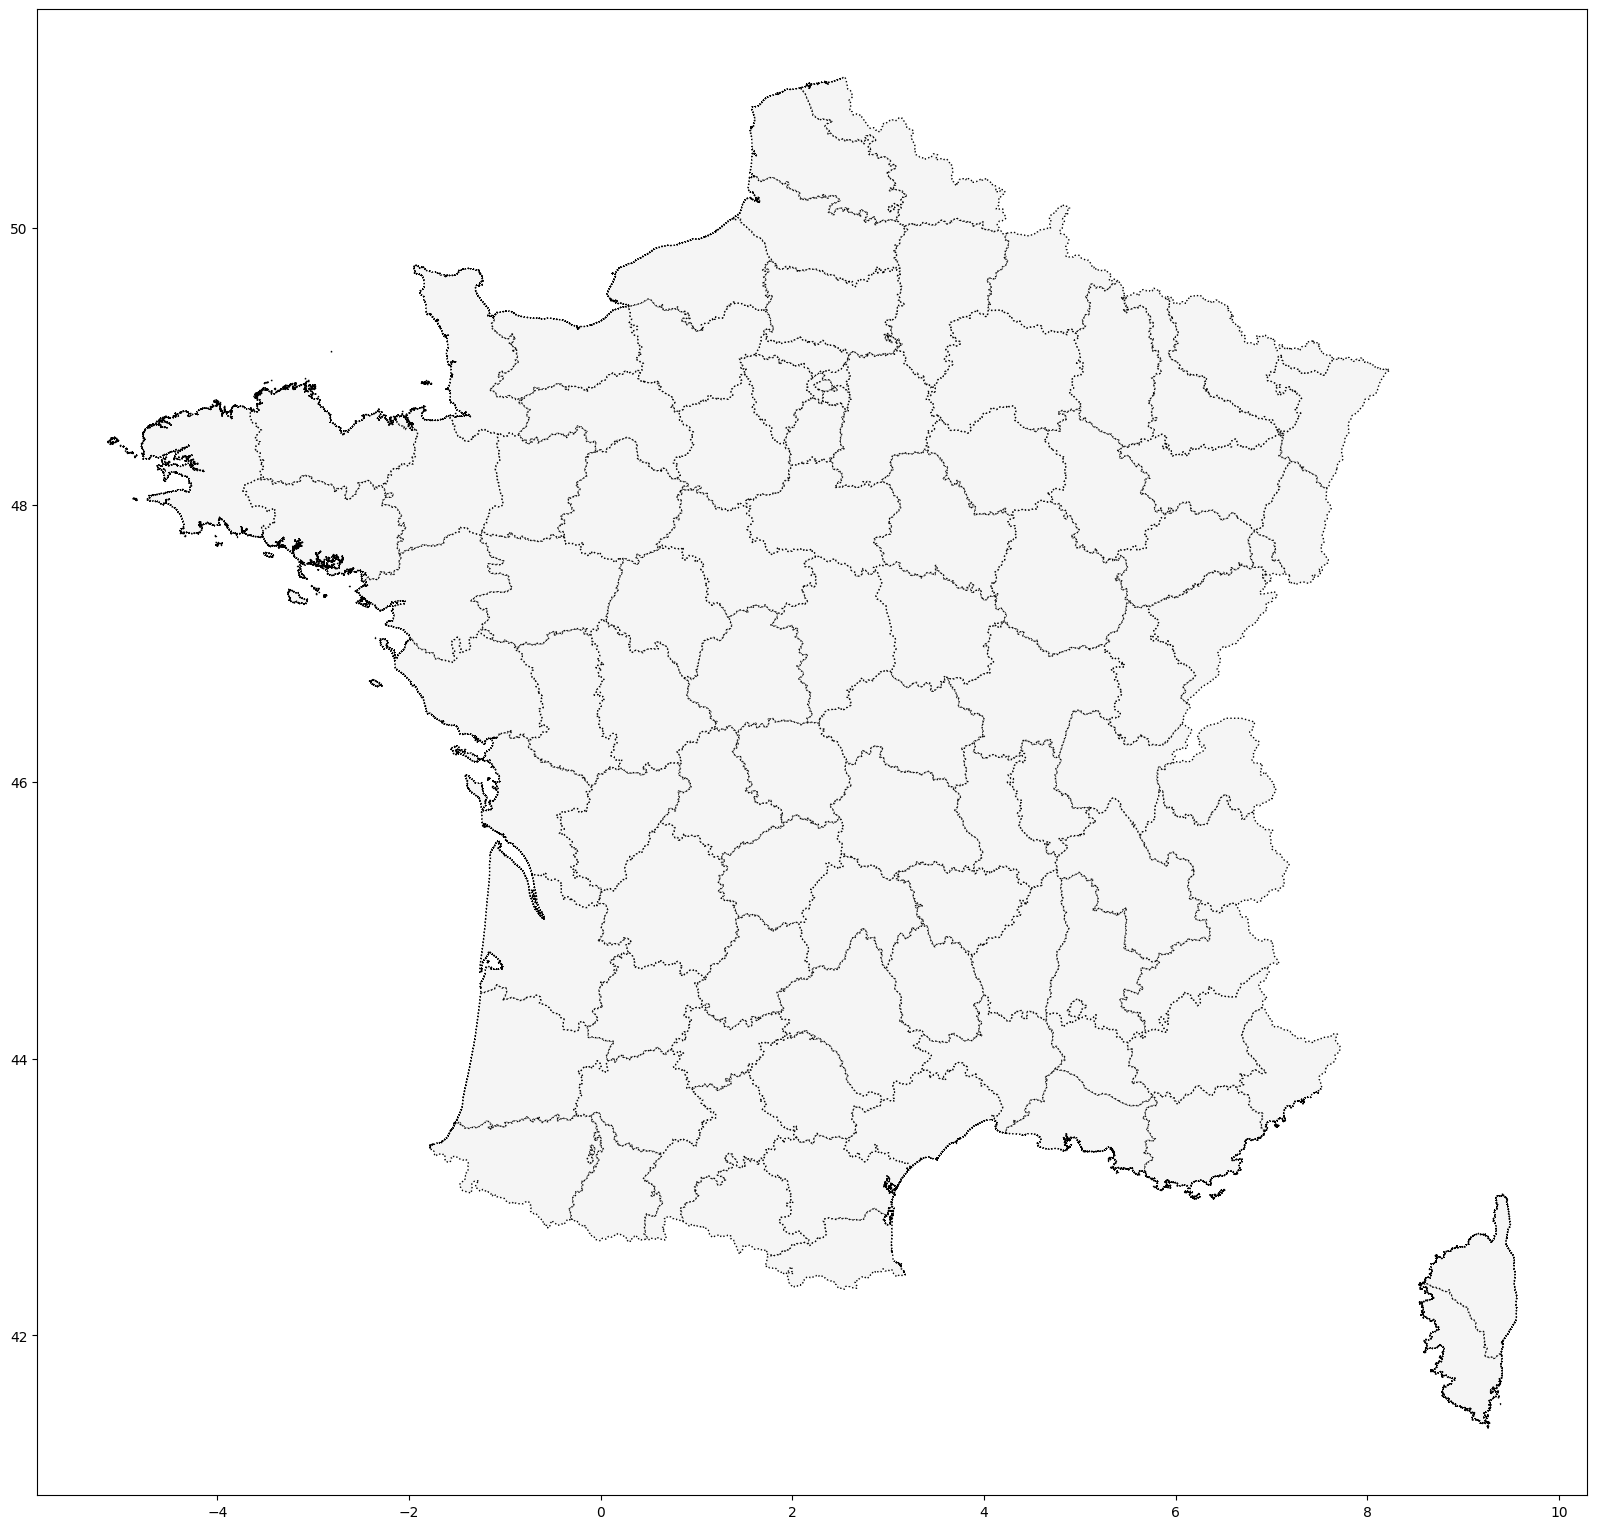

In [ ]:
# Load a GeoDataFrame containing departments in France
regions_level2 = gpd.read_file("../country_boundaries/gadm41_FRA_shp/gadm41_FRA_2.shp")
regions_level2.plot(figsize=(20,20), color='whitesmoke', linestyle=':', edgecolor='black')

In [ ]:
regions_level2[regions_level2['NAME_1'] == 'Pays de la Loire']['NAME_2'].value_counts()


NAME_2
Loire-Atlantique    1
Maine-et-Loire      1
Mayenne             1
Sarthe              1
Vendée              1
Name: count, dtype: int64

<Axes: >

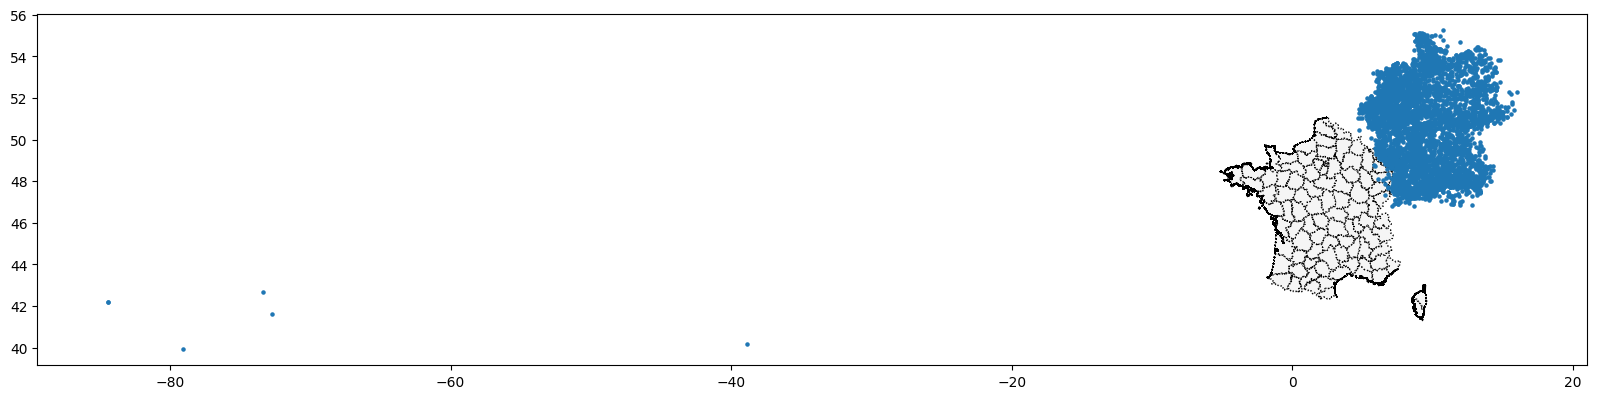

In [ ]:
# Create a map
ax = regions_level2.plot(figsize=(20,20), color='whitesmoke', linestyle=':', edgecolor='black')
facilities.plot(markersize=5, ax=ax)

<Axes: >

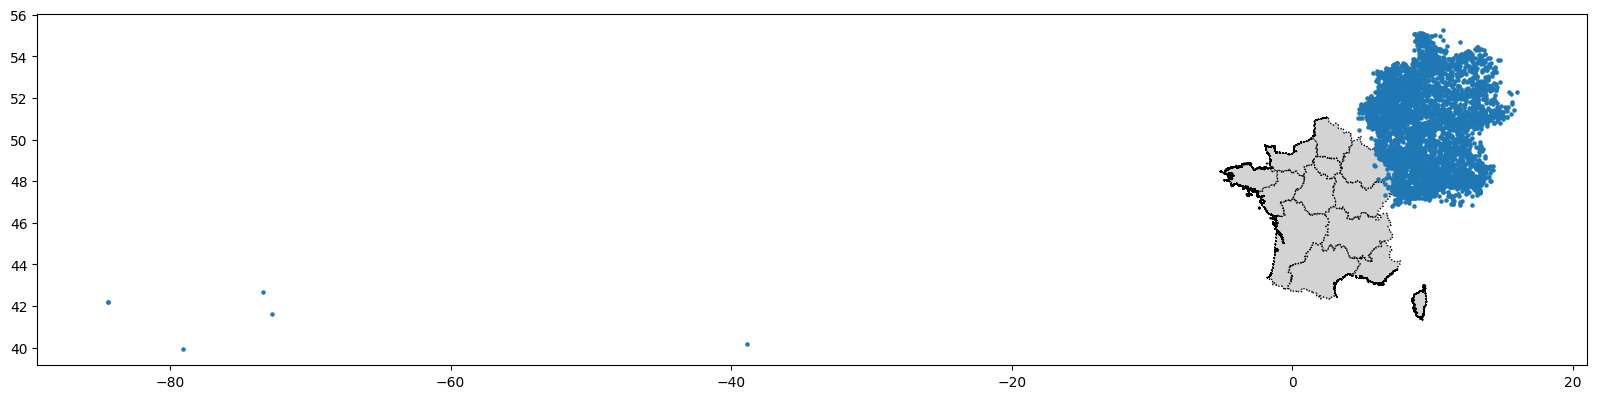

In [ ]:
# Load a GeoDataFrame containing regions in France
regions_level1 = gpd.read_file("../country_boundaries/gadm41_FRA_shp/gadm41_FRA_1.shp")

# Create the map with both layers
ax = regions_level1.plot(figsize=(20,20), color='lightgrey', linestyle=':', edgecolor='black')
facilities.plot(markersize=5, ax=ax)

In [ ]:
regions_level1.head()

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,FRA.1_1,FRA,France,Auvergne-Rhône-Alpes,NA,NA,Région,Region,NA,FR.AR,NA,"POLYGON ((5.41583 44.15465, 5.39695 44.15234, ..."
1,FRA.2_1,FRA,France,Bourgogne-Franche-Comté,NA,NA,Région,Region,NA,FR.BF,NA,"POLYGON ((5.25627 46.45188, 5.24800 46.45937, ..."
2,FRA.3_1,FRA,France,Bretagne,NA,NA,Région,Region,NA,FR.BT,FR-BRE,"MULTIPOLYGON (((-3.24819 47.31070, -3.24764 47..."
3,FRA.4_1,FRA,France,Centre-Val de Loire,NA,NA,Région,Region,NA,FR.CN,FR-CVL,"POLYGON ((2.06346 46.42135, 2.04849 46.42078, ..."
4,FRA.5_1,FRA,France,Corse,Corsica,NA,Région,Region,NA,FR.CE,FR-20R,"MULTIPOLYGON (((9.10208 41.42597, 9.10097 41.4..."


In [ ]:
# Perform a spatial join to assign each farm to a region
joined_gdf = gpd.sjoin(facilities, regions_level2, how="left", op="within")

# Filter farms by region
farms_in_bretagne = joined_gdf[joined_gdf['NAME_1'] == 'Pays de la Loire']

# Aggregate farms by region and count the number of farms in each region
farms_by_region = farms_in_bretagne.groupby('NAME_1')['name'].count()


/Users/rodrigoazevedo/repos/geopandas/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/kj/s6p553_17zxd38q2s490jgr80000gn/T/ipykernel_7770/2161365679.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  joined_gdf = gpd.sjoin(facilities, regions_level2, how="left", op="within")


In [ ]:
farms_by_region.head()

Series([], Name: name, dtype: int64)

In [ ]:
# Perform a spatial join to assign each farm to a department
joined_gdf2 = gpd.sjoin(facilities, regions_level2, how="left", op="within")



# Aggregate farms by department and count the number of farms in each department
farms_by_department = joined_gdf2.groupby('NAME_2')['name'].count()
farms_by_department.head()
# Select only the desired columns
desired_columns = ['NAME_1', 'NAME_2']
joined_gdf_filtered = joined_gdf[desired_columns]
# Merge the filtered spatial join result with the original facilities DataFrame
joined_gdf_final = facilities.merge(joined_gdf_filtered, left_index=True, right_index=True)

# Filter farms by department
farms_in_Côtes_dArmor = joined_gdf_final[joined_gdf_final['NAME_2'] == "Côtes-d'Armor"]
#Finistère Ille-et-Vilaine    1
#Morbihan
farms_in_Finistère = joined_gdf_final[joined_gdf_final['NAME_2'] == "Finistère"]
farms_in_Ille_et_Vilaine = joined_gdf_final[joined_gdf_final['NAME_2'] == "Ille-et-Vilaine"]
farms_in_Morbihan = joined_gdf_final[joined_gdf_final['NAME_2'] == "Morbihan"]

/Users/rodrigoazevedo/repos/geopandas/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/kj/s6p553_17zxd38q2s490jgr80000gn/T/ipykernel_7770/532751814.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  joined_gdf2 = gpd.sjoin(facilities, regions_level2, how="left", op="within")


In [ ]:
joined_gdf_final.head()

,name,website,main_category,categories,phone,address,coordinates,link,latitude,longitude,animal_type,geometry,NAME_1,NAME_2
0,HONEST CATCH - CrustaNova GmbH | Garnelenzucht...,https://www.honest-catch.com/,shrimp_farm,[shrimp_farm],089 215508813,HONEST CATCH - CrustaNova GmbH | Garnelenzucht...,"48.4322624,11.9793574",https://www.google.com/maps/place/HONEST+CATCH...,48.4322624,11.9793574,fish,POINT (11.97936 48.43226),NaN,NaN
1,"Biohof Silbernagl, Weiderinder - Brennholz - A...",http://biohof-silbernagl.de/,multiple,"[cattle_farm, poultry_farm]",01522 8734396,"Biohof Silbernagl, Weiderinder - Brennholz - A...","48.150031899999995,11.059641599999999",https://www.google.com/maps/place/Biohof+Silbe...,48.150031899999995,11.059641599999999,other,POINT (11.05964 48.15003),NaN,NaN
2,Fischfarm-Koicenter,http://www.fischfarm-koicenter.de/,fish_farm,[fish_farm],04639 781620,"Fischfarm-Koicenter, Flensburger Ch 2, 24980 S...","54.762404999999994,9.194253999999999",https://www.google.com/maps/place/Fischfarm-Ko...,54.762404999999994,9.194253999999999,fish,POINT (9.19425 54.76240),NaN,NaN
3,Dresdner Molkerei Gebruder Pfund GmbH,https://www.pfunds.de/,dairy,[dairy],0351 808080,"Dresdner Molkerei Gebruder Pfund GmbH, Bautzne...","51.0637639,13.7598407",https://www.google.com/maps/place/Dresdner+Mol...,51.0637639,13.7598407,cows,POINT (13.75984 51.06376),NaN,NaN
4,Krewelshof Lohmar,https://krewelshof.de/,dairy,[dairy],02205 897706,"Krewelshof Lohmar, Krewelshof 1, 53797 Lohmar","50.8726366,7.198050299999999",https://www.google.com/maps/place/Krewelshof+L...,50.8726366,7.198050299999999,cows,POINT (7.19805 50.87264),NaN,NaN


In [ ]:
joined_gdf_final.NAME_1.value_counts()

NAME_1
Grand Est                  345
Bourgogne-Franche-Comté      4
Name: count, dtype: int64

In [ ]:
farms_in_bretagne = joined_gdf_final[joined_gdf_final['NAME_1'] == 'Bretagne']
farms_in_bretagne.NAME_2.value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
farms_in_Côtes_dArmor.head()

,name,website,main_category,categories,phone,address,coordinates,link,latitude,longitude,animal_type,geometry,NAME_1,NAME_2


In [ ]:
farms_in_Côtes_dArmor.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 0 entries
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   name           0 non-null      object  
 1   website        0 non-null      object  
 2   main_category  0 non-null      object  
 3   categories     0 non-null      object  
 4   phone          0 non-null      object  
 5   address        0 non-null      object  
 6   coordinates    0 non-null      object  
 7   link           0 non-null      object  
 8   latitude       0 non-null      object  
 9   longitude      0 non-null      object  
 10  animal_type    0 non-null      object  
 11  geometry       0 non-null      geometry
 12  NAME_1         0 non-null      object  
 13  NAME_2         0 non-null      object  
dtypes: geometry(1), object(13)
memory usage: 0.0+ bytes


ValueError: aspect must be finite and positive 

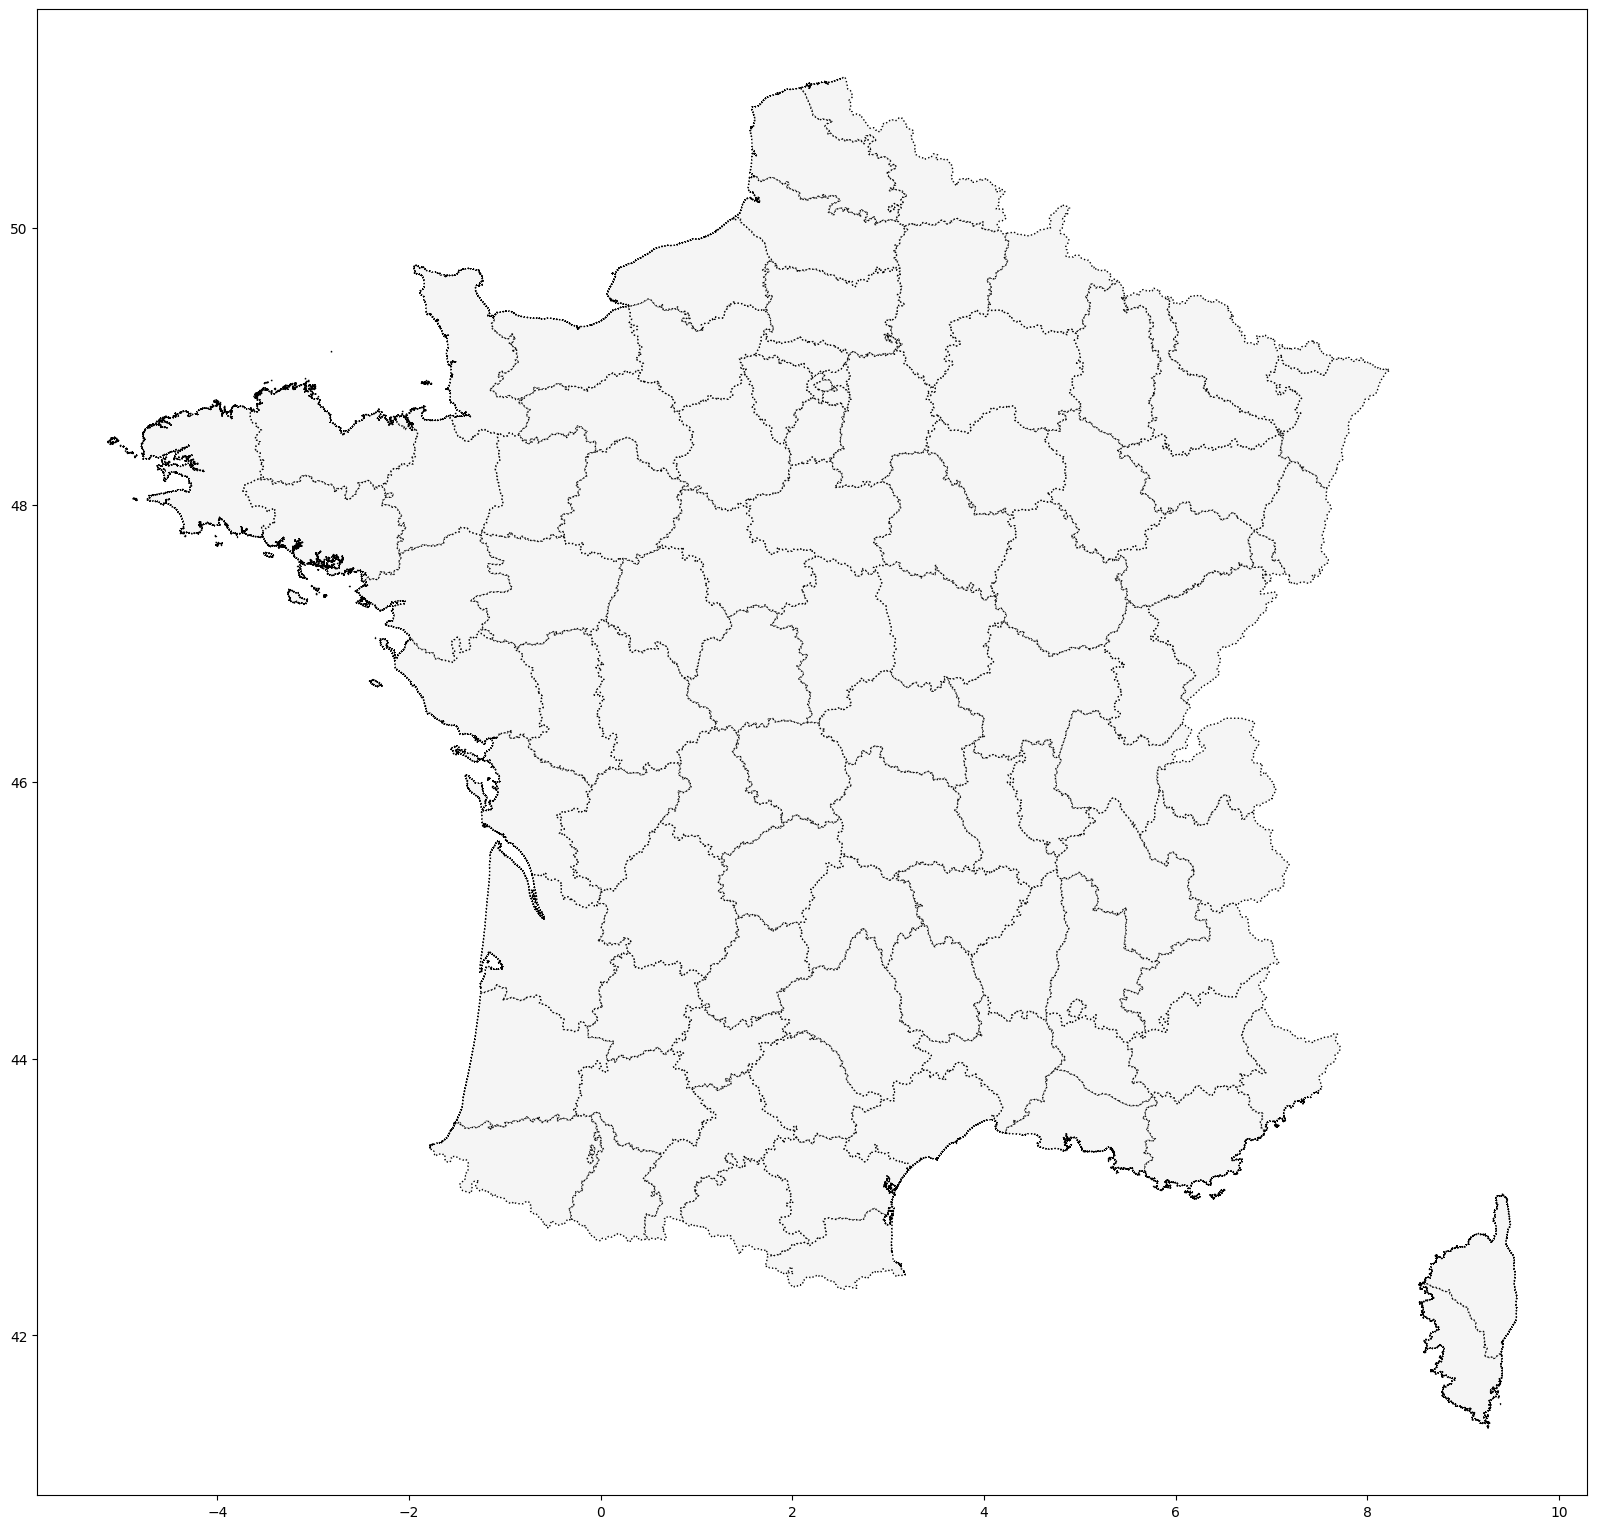

In [ ]:
# Create a map
ax = regions_level2.plot(figsize=(20,20), color='whitesmoke', linestyle=':', edgecolor='black')
farms_in_Côtes_dArmor.plot(markersize=5, ax=ax)
farms_in_Finistère.plot(markersize=5, ax=ax)
farms_in_Ille_et_Vilaine.plot(markersize=5, ax=ax)
farms_in_Morbihan.plot(markersize=5, ax=ax)

<Axes: >

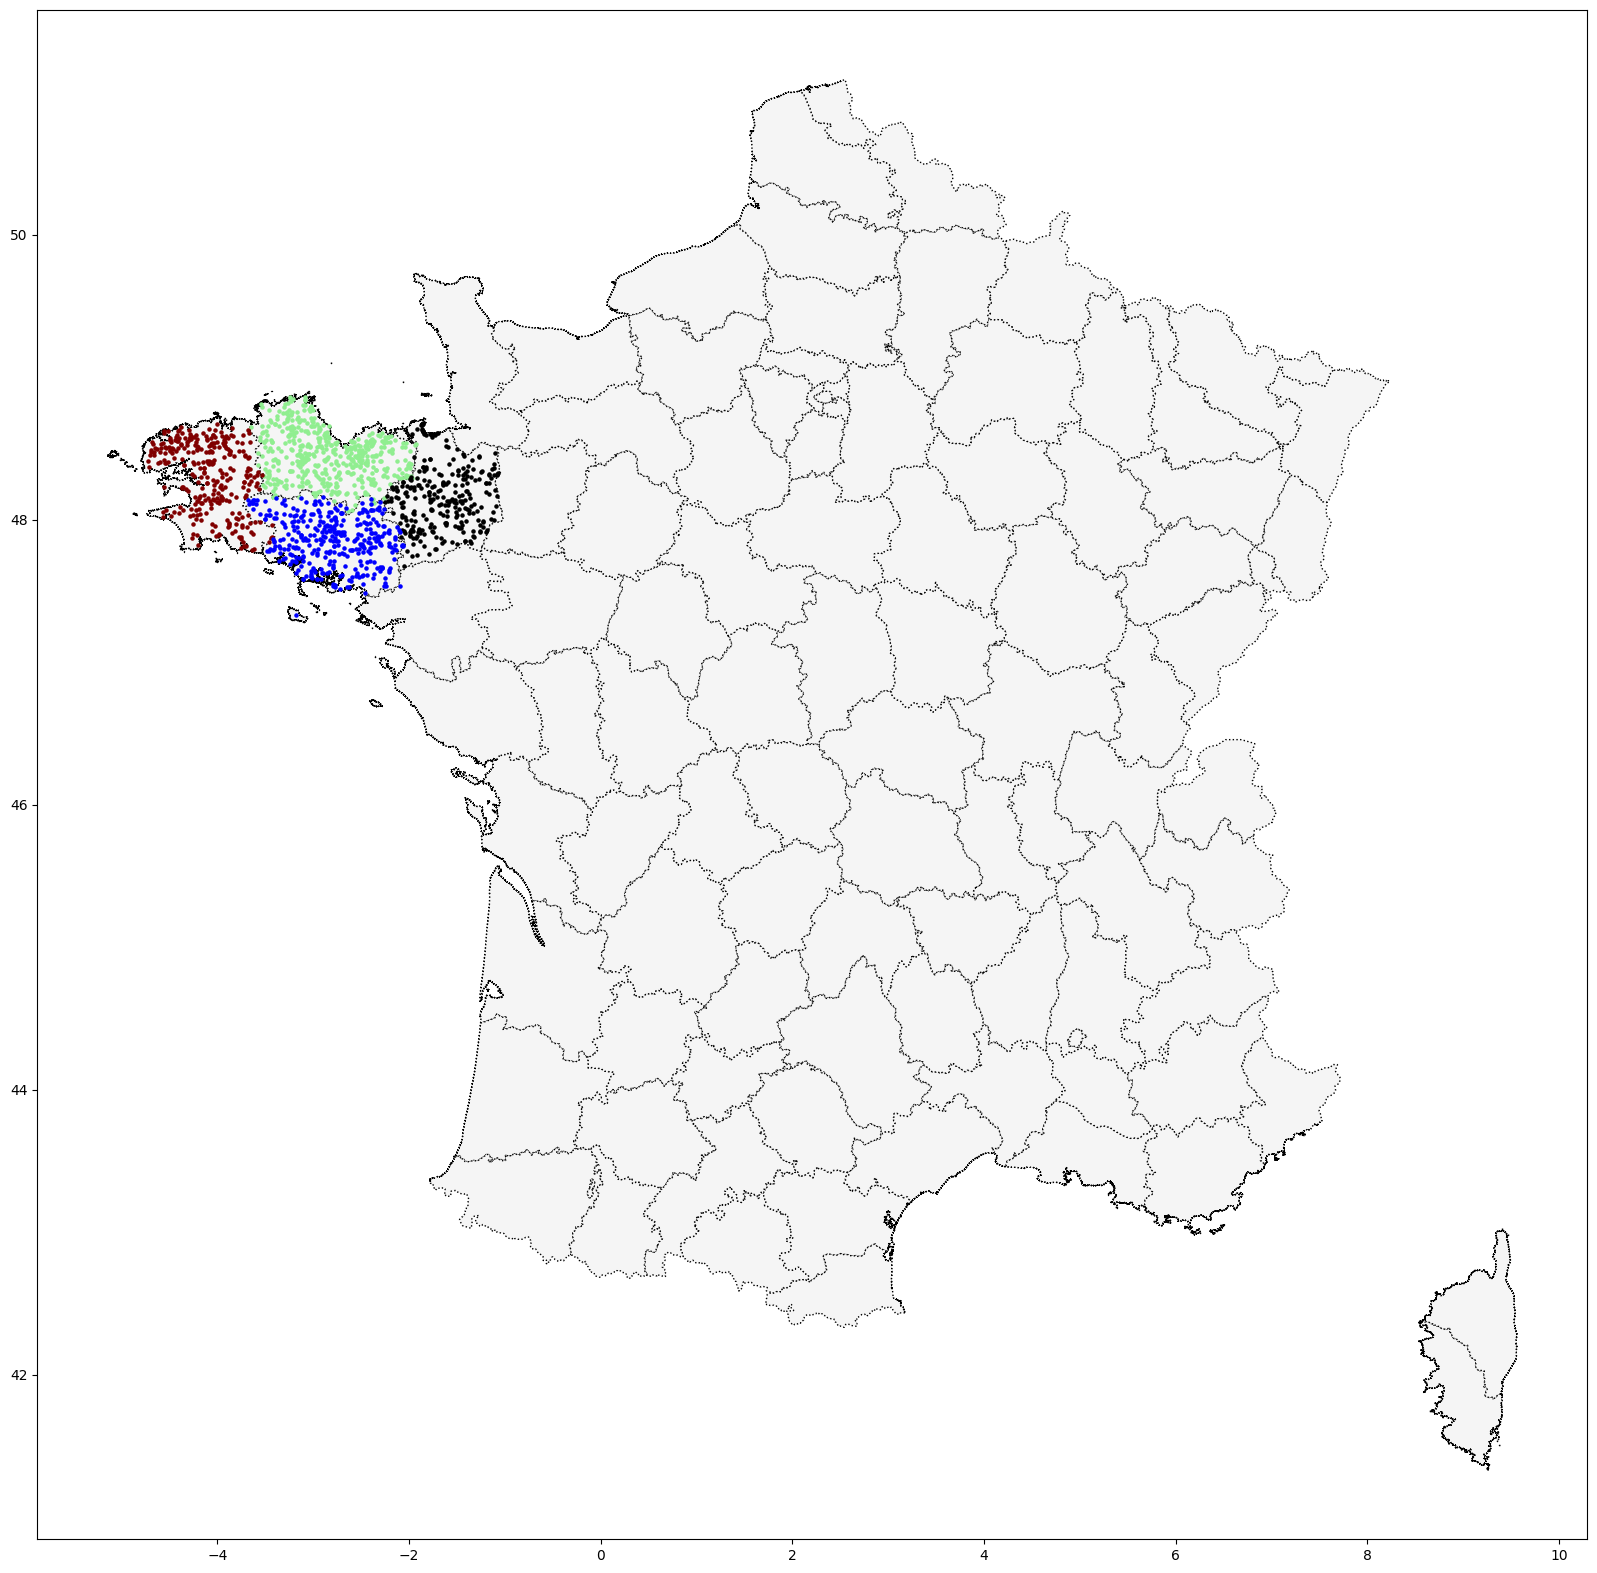

In [ ]:

# Create a map
ax = regions_level2.plot(figsize=(20,20), color='whitesmoke', linestyle=':', edgecolor='black', zorder=1)

# Plot farms in each region with assigned colors
farms_in_Côtes_dArmor.plot(color='lightgreen', markersize=5, ax=ax, zorder=2)
farms_in_Finistère.plot(color='maroon', markersize=5, ax=ax, zorder=2)
farms_in_Ille_et_Vilaine.plot(color='black', markersize=5, ax=ax, zorder=2)
farms_in_Morbihan.plot(color='blue', markersize=5, ax=ax, zorder=2)

<Axes: >

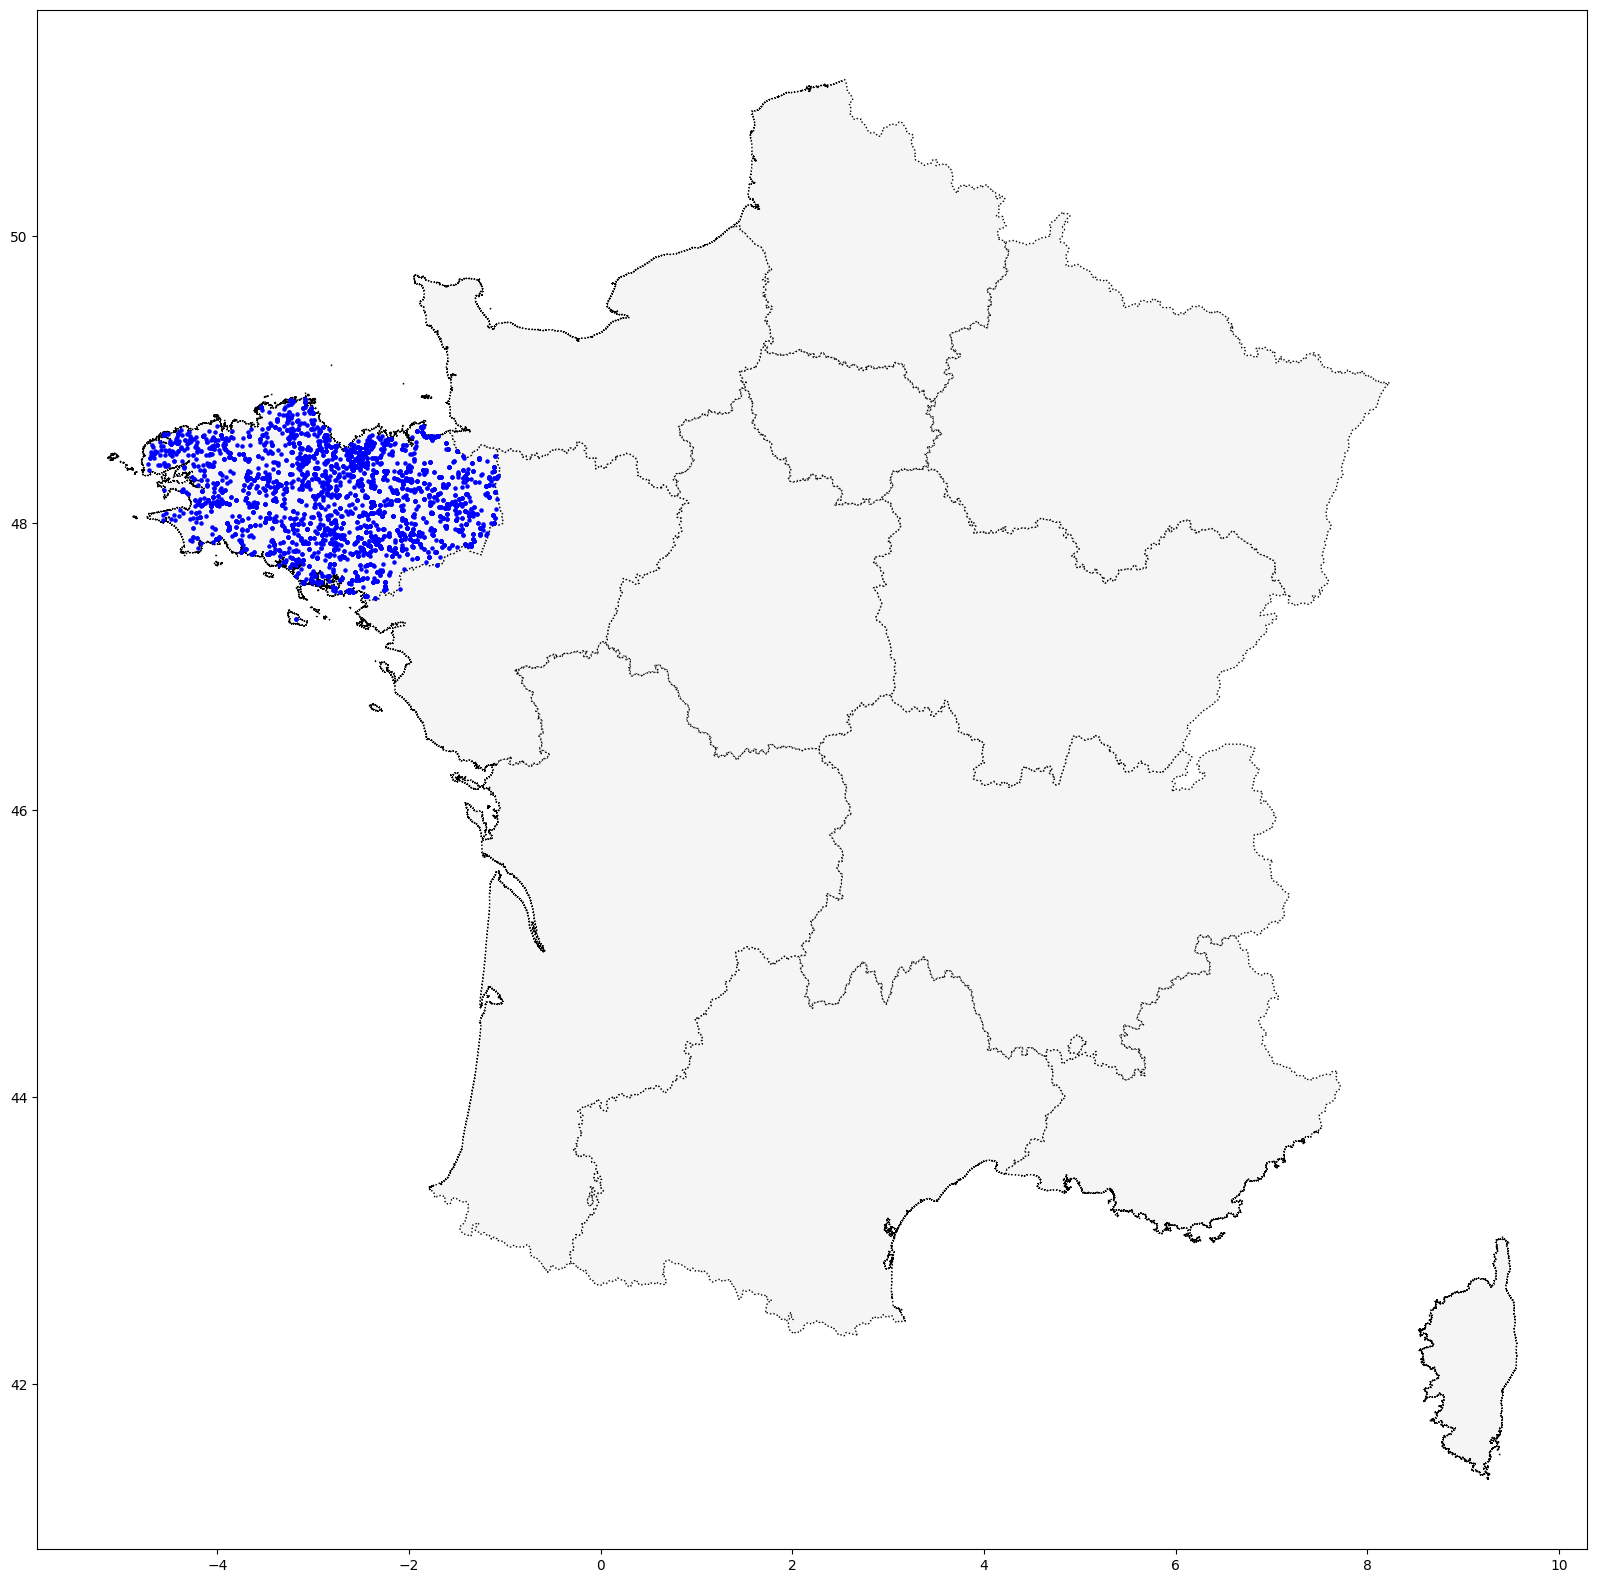

In [ ]:
farms_in_bretagne 

# Create a map
ax = regions_level1.plot(figsize=(20,20), color='whitesmoke', linestyle=':', edgecolor='black', zorder=1)

# Plot farms in each region with assigned colors
farms_in_bretagne.plot(color='blue', markersize=5, ax=ax, zorder=2)

0     Annotation(4.54529, 45.5179, 'Auvergne-Rhône-A...
1     Annotation(4.80692, 47.2342, 'Bourgogne-Franch...
2              Annotation(-2.84511, 48.179, 'Bretagne')
3     Annotation(1.68439, 47.4848, 'Centre-Val de Lo...
4                 Annotation(9.10559, 42.1515, 'Corse')
5             Annotation(5.61328, 48.6887, 'Grand Est')
6       Annotation(2.77043, 49.9697, 'Hauts-de-France')
7         Annotation(2.50347, 48.7092, 'Île-de-France')
8            Annotation(0.108212, 49.1199, 'Normandie')
9     Annotation(0.212187, 45.2059, 'Nouvelle-Aquita...
10            Annotation(2.14237, 43.7032, 'Occitanie')
11    Annotation(-0.815496, 47.4777, 'Pays de la Loi...
12    Annotation(6.05871, 43.9575, "Provence-Alpes-C...
dtype: object

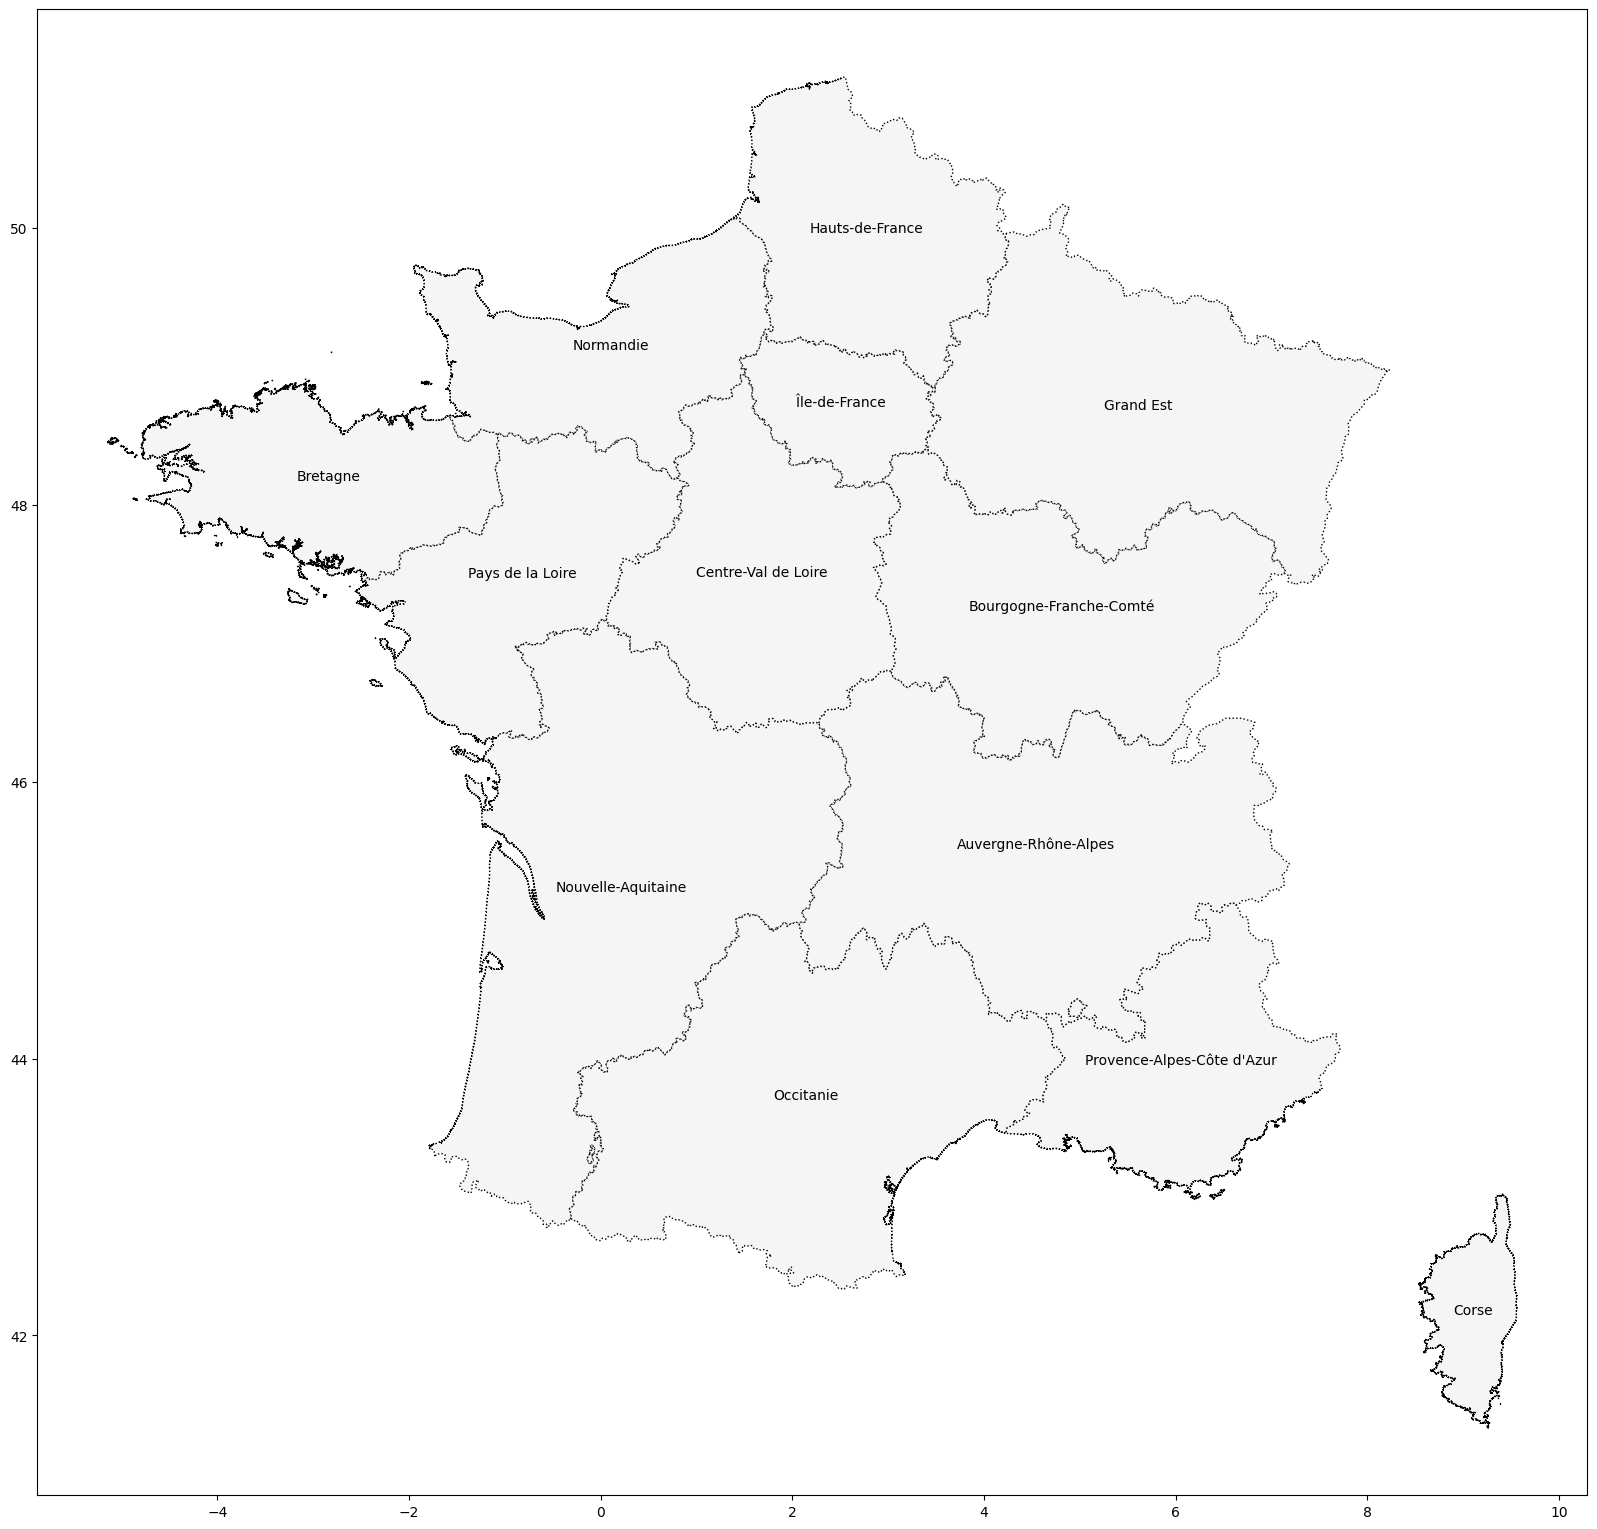

In [ ]:
# create a map with the names of the regions
ax = regions_level1.plot(figsize=(20,20), color='whitesmoke', linestyle=':', edgecolor='black', zorder=1)
regions_level1.apply(lambda x: ax.annotate(text=x.NAME_1, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

